Training Deep Q-Learning Agent with Changing Target Goals...
Grid Size: 10x10
Number of Goals: 3
Number of Obstacles: 5
Episodes: 1000

Episode 100/1000 - Avg Reward: 43.64, Avg Steps: 50.29, Avg Loss: 33.7639, Most Common Goal: 1, Epsilon: 0.606
Episode 200/1000 - Avg Reward: 85.63, Avg Steps: 15.37, Avg Loss: 6.3233, Most Common Goal: 2, Epsilon: 0.367
Episode 300/1000 - Avg Reward: 90.03, Avg Steps: 10.97, Avg Loss: 2.9045, Most Common Goal: 1, Epsilon: 0.222
Episode 400/1000 - Avg Reward: 92.46, Avg Steps: 8.54, Avg Loss: 1.7559, Most Common Goal: 1, Epsilon: 0.135
Episode 500/1000 - Avg Reward: 93.05, Avg Steps: 7.95, Avg Loss: 1.1606, Most Common Goal: 2, Epsilon: 0.082
Episode 600/1000 - Avg Reward: 93.35, Avg Steps: 7.65, Avg Loss: 0.8545, Most Common Goal: 1, Epsilon: 0.049
Episode 700/1000 - Avg Reward: 93.47, Avg Steps: 7.53, Avg Loss: 0.7015, Most Common Goal: 2, Epsilon: 0.030
Episode 800/1000 - Avg Reward: 93.49, Avg Steps: 7.51, Avg Loss: 0.4795, Most Common Goal: 1, Eps

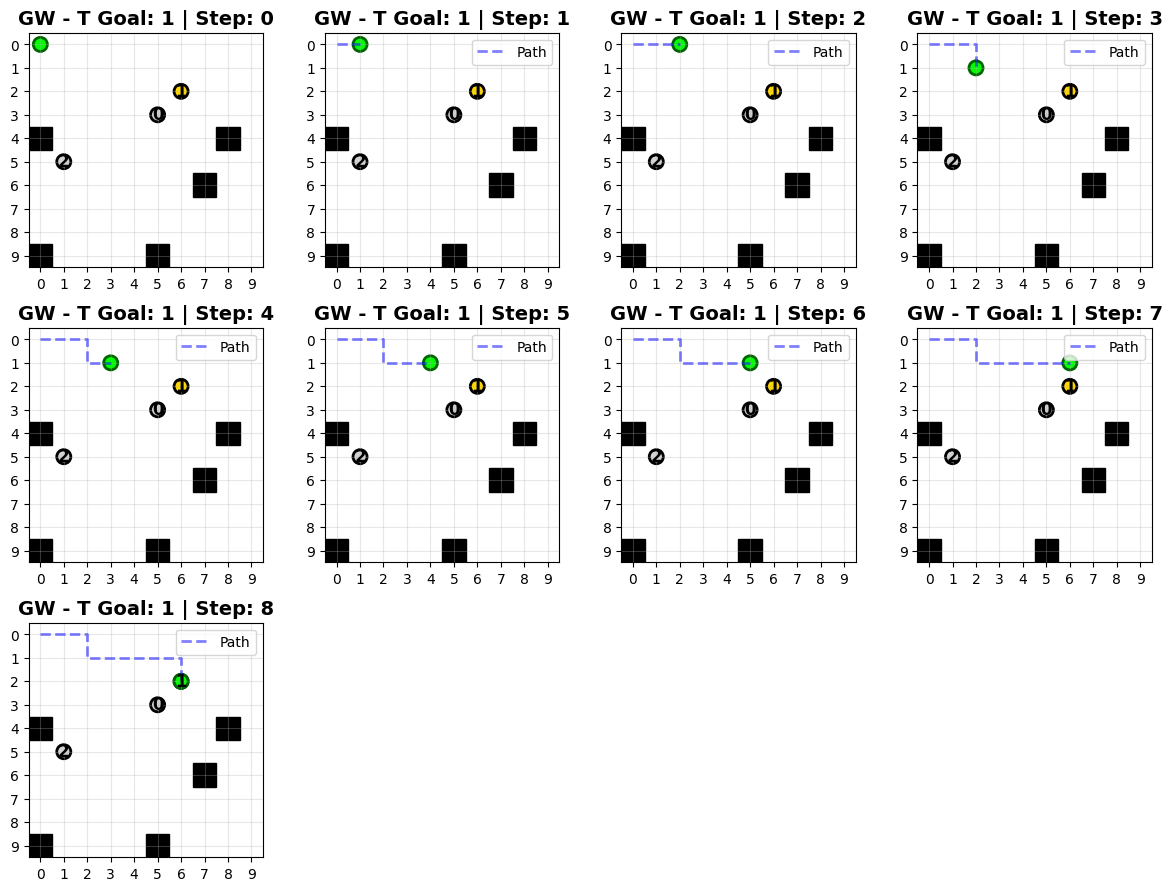

✓ Training metrics saved as 'gridworld_dql_training.png'


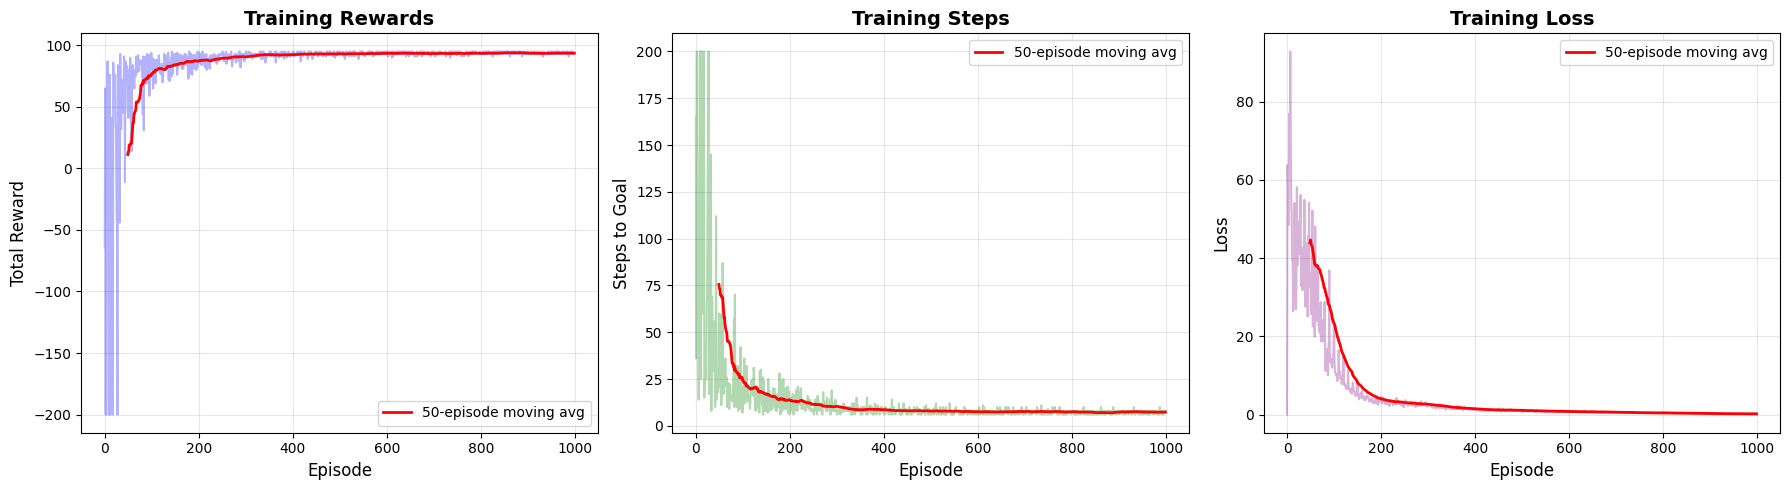


RESULTS:
Goal reached: True
Total steps taken: 8
Final position: [2 6]
Target goal position: [2 6]
Path length: 9
All positions visited: 9



In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional, Tuple, List
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

class MultiGoalGridWorld(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 10):
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Define action and observation space
        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: [agent_x, agent_y, goal_x, goal_y]
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(4,), dtype=np.int32
        )

        # Initialize positions
        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        # Get all available positions (excluding agent start)
        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        # Total positions needed
        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))

        # Randomly select positions
        selected_indices = np.random.choice(
            len(available_positions),
            size=total_needed,
            replace=False
        )

        # Assign goals
        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        # Assign obstacles
        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        for obs in self.obstacles:
            if np.array_equal(pos, obs):
                return True
        return False

    def _get_obs(self):
        target_pos = self.goals[self.target_goal]
        return np.concatenate([self.agent_pos, target_pos]).astype(np.int32)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        # Reset agent to fixed start position
        self.agent_pos = np.array([0, 0])

        # Ensure target_goal is valid
        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self._get_obs(), {}

    def step(self, action: int):
        # Map actions to movements
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        # Calculate new position
        new_pos = self.agent_pos + direction_map[action]

        # Check boundaries
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        # Check if new position is an obstacle
        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        # Check if reached target goal
        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        # Calculate reward
        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0  # Step penalty
            terminated = False

        truncated = False

        return self._get_obs(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        # Draw obstacles
        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        # Draw goals
        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        # Draw agent path if provided
        if agent_path and len(agent_path) > 1:
            path_array = np.array([p[:2] for p in agent_path])  # Use only agent position
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2, label='Path')

        # Draw agent
        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GW - T Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            ax.legend(loc='upper right')

        return ax


class QNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class DQLAgent:
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0005,
                 discount_factor: float = 0.95, epsilon: float = 1.0,
                 epsilon_decay: float = 0.995, epsilon_min: float = 0.01,
                 buffer_size: int = 10000, batch_size: int = 64):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        # Initialize networks
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)  # Explore
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()  # Exploit

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute current Q-values
        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss
        loss = nn.MSELoss()(q_values, targets)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()  # Return loss for logging

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


def train_and_visualize(grid_size=10, num_goals=3, num_obstacles=15, episodes=1000):

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=grid_size,
        target_goal=0,  # Initial target goal (will change per episode)
        num_goals=num_goals,
        num_obstacles=num_obstacles
    )

    # Create agent
    agent = DQLAgent(
        state_size=4,  # [agent_x, agent_y, goal_x, goal_y]
        action_size=env.action_space.n,
        learning_rate=0.0005,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=64
    )

    # Training metrics
    episode_rewards = []
    episode_steps = []
    episode_goals = []
    episode_losses = []

    print("Training Deep Q-Learning Agent with Changing Target Goals...")
    print(f"Grid Size: {grid_size}x{grid_size}")
    print(f"Number of Goals: {num_goals}")
    print(f"Number of Obstacles: {num_obstacles}")
    print(f"Episodes: {episodes}\n")

    # Training loop
    target_update_freq = 10  # Update target network every 10 episodes
    for episode in range(episodes):
        # Set a new random target goal for this episode
        env.target_goal = np.random.randint(0, num_goals)
        episode_goals.append(env.target_goal)

        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:  # Max steps per episode
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            agent.memory.push(state, action, reward, next_state, done)

            # Update Q-network
            loss = agent.update()
            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        # Update target network
        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            avg_loss = np.mean(episode_losses[-100:])
            most_common_goal = np.bincount(episode_goals[-100:]).argmax()
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Avg Loss: {avg_loss:.4f}, "
                  f"Most Common Goal: {most_common_goal}, "
                  f"Epsilon: {agent.epsilon:.3f}")

    print("\n✓ Training Complete!\n")

    # Test the trained agent with visualization
    print("Testing Trained Agent (ALL Steps Visualization)...")
    env.target_goal = np.random.randint(0, num_goals)  # Random goal for testing
    print(f"Testing with Target Goal: {env.target_goal}")
    state, _ = env.reset()
    done = False
    steps = 0
    agent_path = [state.copy()]
    all_positions = [state.copy()]

    while not done and steps < 200:
        action = agent.get_action(state)
        agent.epsilon = 0  # Use greedy policy for testing

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        all_positions.append(next_state.copy())
        state = next_state
        steps += 1

    print(f"Agent took {steps} steps to reach the goal!")
    print(f"Creating visualization for ALL {steps} steps...\n")

    # Calculate grid layout for all steps
    total_steps = len(all_positions)

    # Determine grid layout based on number of steps
    if total_steps <= 6:
        rows, cols = 2, 3
    elif total_steps <= 12:
        rows, cols = 3, 4
    elif total_steps <= 20:
        rows, cols = 4, 5
    elif total_steps <= 30:
        rows, cols = 5, 6
    else:
        rows, cols = 6, 8

    # Create multiple figures if needed
    steps_per_figure = rows * cols
    num_figures = (total_steps + steps_per_figure - 1) // steps_per_figure

    for fig_num in range(num_figures):
        start_idx = fig_num * steps_per_figure
        end_idx = min(start_idx + steps_per_figure, total_steps)
        steps_in_fig = end_idx - start_idx

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()

        print(f"Generating figure {fig_num + 1}/{num_figures} (Steps {start_idx} to {end_idx - 1})...")

        for i in range(steps_per_figure):
            ax = axes[i]
            step_idx = start_idx + i

            if step_idx < total_steps:
                env.agent_pos = all_positions[step_idx][:2]  # Use only agent position
                current_path = all_positions[:step_idx + 1]
                env.render_grid(ax, agent_path=current_path, current_step=step_idx)
            else:
                ax.axis('off')

        plt.tight_layout()
        filename = f'gridworld_all_steps_part{fig_num + 1}.png'
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {filename}")
        plt.show()

    # Plot training metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot rewards
    ax1.plot(episode_rewards, alpha=0.3, color='blue')
    window = 50
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Training Rewards', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot steps
    ax2.plot(episode_steps, alpha=0.3, color='green')
    if len(episode_steps) >= window:
        moving_avg = np.convolve(episode_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_steps)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Steps to Goal', fontsize=12)
    ax2.set_title('Training Steps', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot losses
    ax3.plot(episode_losses, alpha=0.3, color='purple')
    if len(episode_losses) >= window:
        moving_avg = np.convolve(episode_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(episode_losses)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode moving avg')
    ax3.set_xlabel('Episode', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('gridworld_dql_training.png', dpi=150, bbox_inches='tight')
    print(f"✓ Training metrics saved as 'gridworld_dql_training.png'")
    plt.show()

    print(f"\n{'='*60}")
    print(f"RESULTS:")
    print(f"{'='*60}")
    print(f"Goal reached: {done}")
    print(f"Total steps taken: {steps}")
    print(f"Final position: {state[:2]}")
    print(f"Target goal position: {env.goals[env.target_goal]}")
    print(f"Path length: {len(agent_path)}")
    print(f"All positions visited: {len(all_positions)}")
    print(f"{'='*60}\n")

    return env, agent, episode_rewards, episode_steps, episode_goals, episode_losses


# Run the training and visualization
if __name__ == "__main__":
    env, agent, rewards, steps, goals, losses = train_and_visualize(
        grid_size=10,
        num_goals=3,
        num_obstacles=5,
        episodes=1000
    )

In [ ]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.1/951.1 kB 20.2 MB/s eta 0:00:00


In [ ]:
pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.4 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
|    loss             | 4.48     |
|    n_updates        | 5994     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.2     |
|    ep_rew_mean      | 78.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 492      |
|    fps              | 606      |
|    time_elapsed     | 41       |
|    total_timesteps  | 25391    |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 3.01     |
|    n_updates        | 6097     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.1     |
|    ep_rew_mean      | 77.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 496      |
|    fps              | 605      |
|    time_elapsed     | 42       |
|   

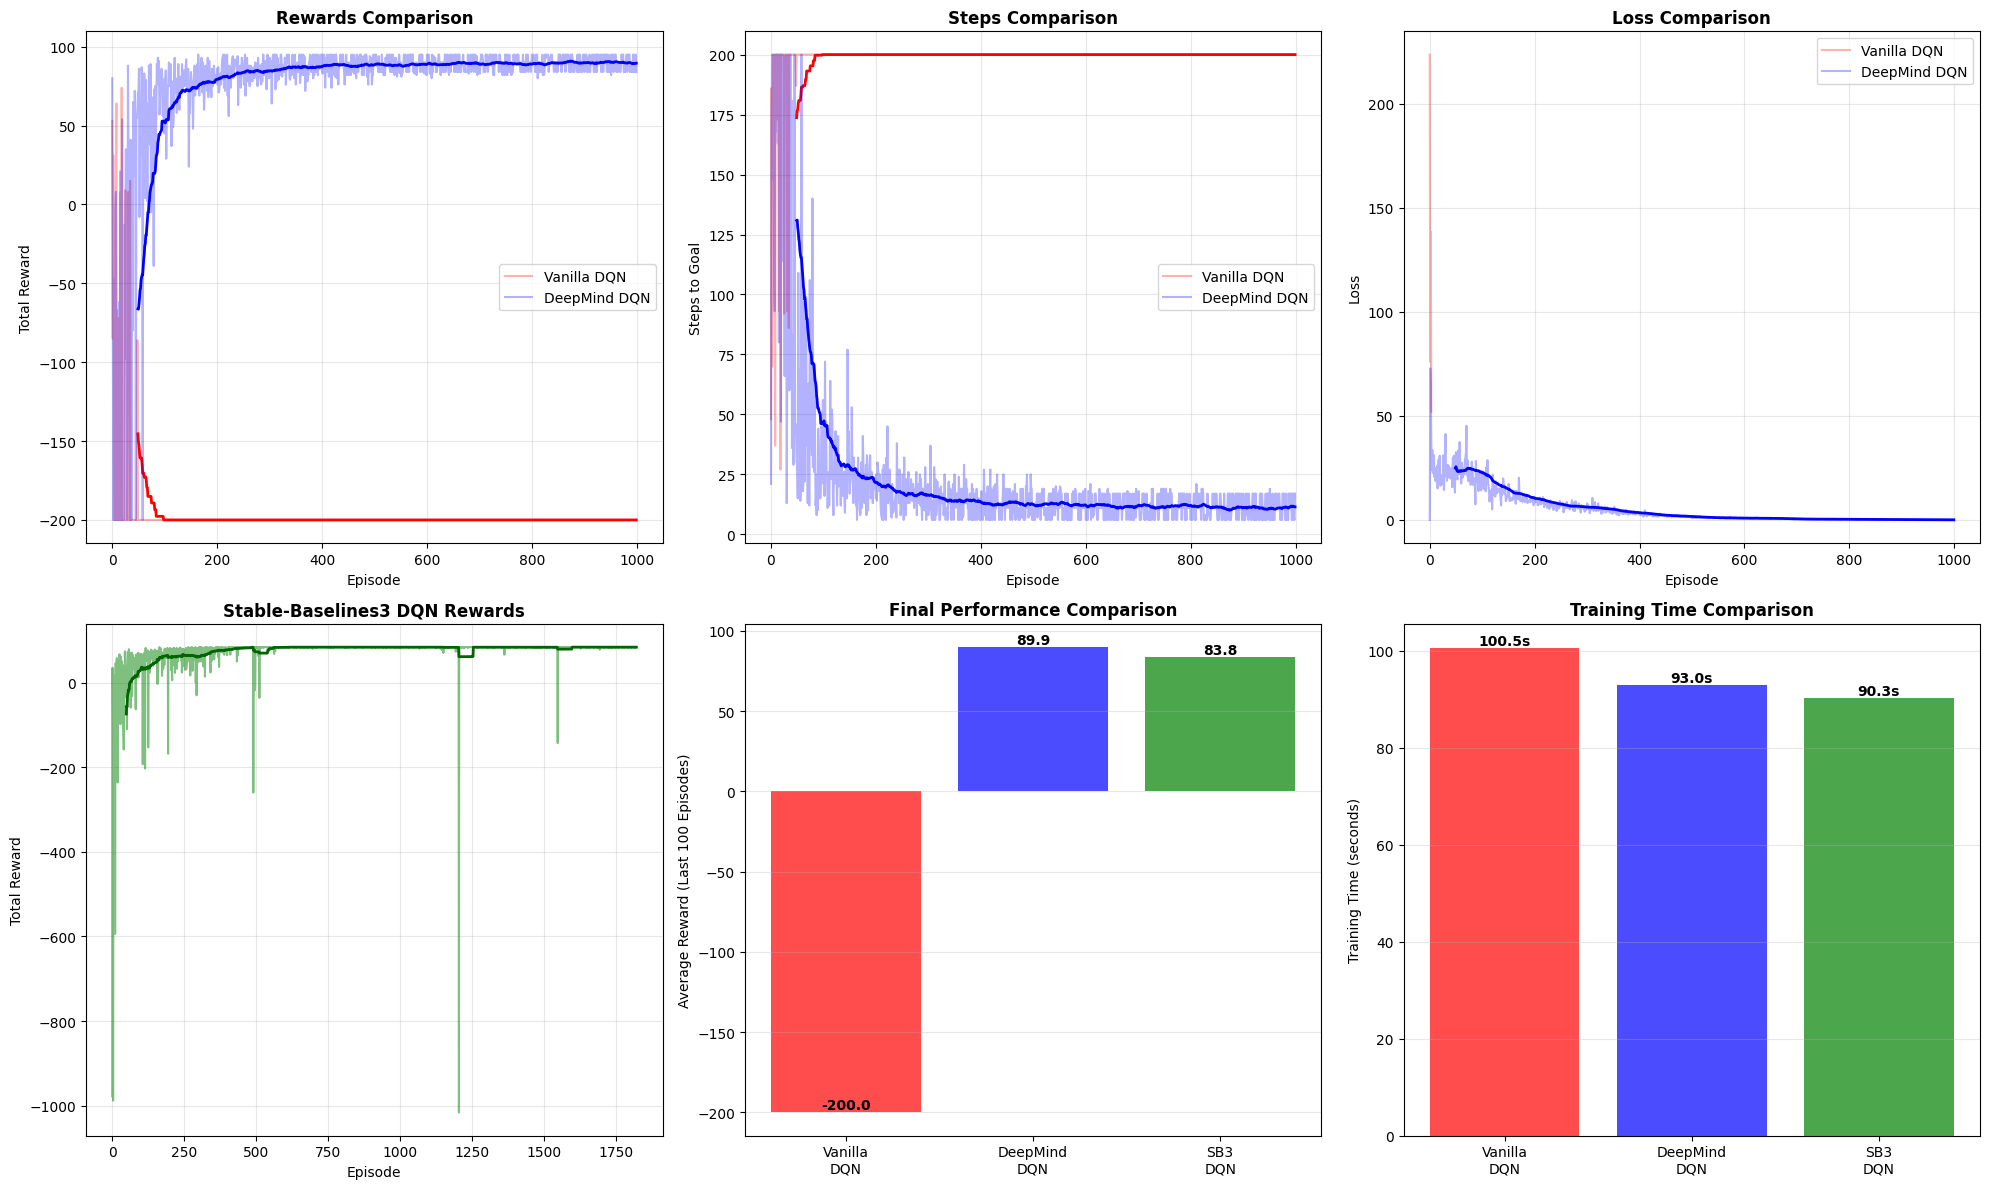


COMPARISON SUMMARY

Algorithm                 Avg Reward      Avg Steps       Time (s)       
----------------------------------------------------------------------
Vanilla DQN               -200.00         200.00          100.52         
DeepMind DQN              89.86           11.14           92.98          
Stable-Baselines3 DQN     83.79           17.21           90.28          

Key Improvements in DeepMind DQN:
  1. Experience Replay Buffer - breaks correlation in sequential data
  2. Target Network - stabilizes learning by fixing targets
  3. Batch Updates - more stable gradient estimates
  4. Adam Optimizer - adaptive learning rates
  5. Deeper Network - more representational capacity

Stable-Baselines3 Additional Features:
  - Optimized implementation with extensive testing
  - Learning rate scheduling
  - Gradient clipping
  - Polyak averaging for target updates
  - Better exploration strategies
  - Logging and monitoring tools


Generating detailed comparison visualization

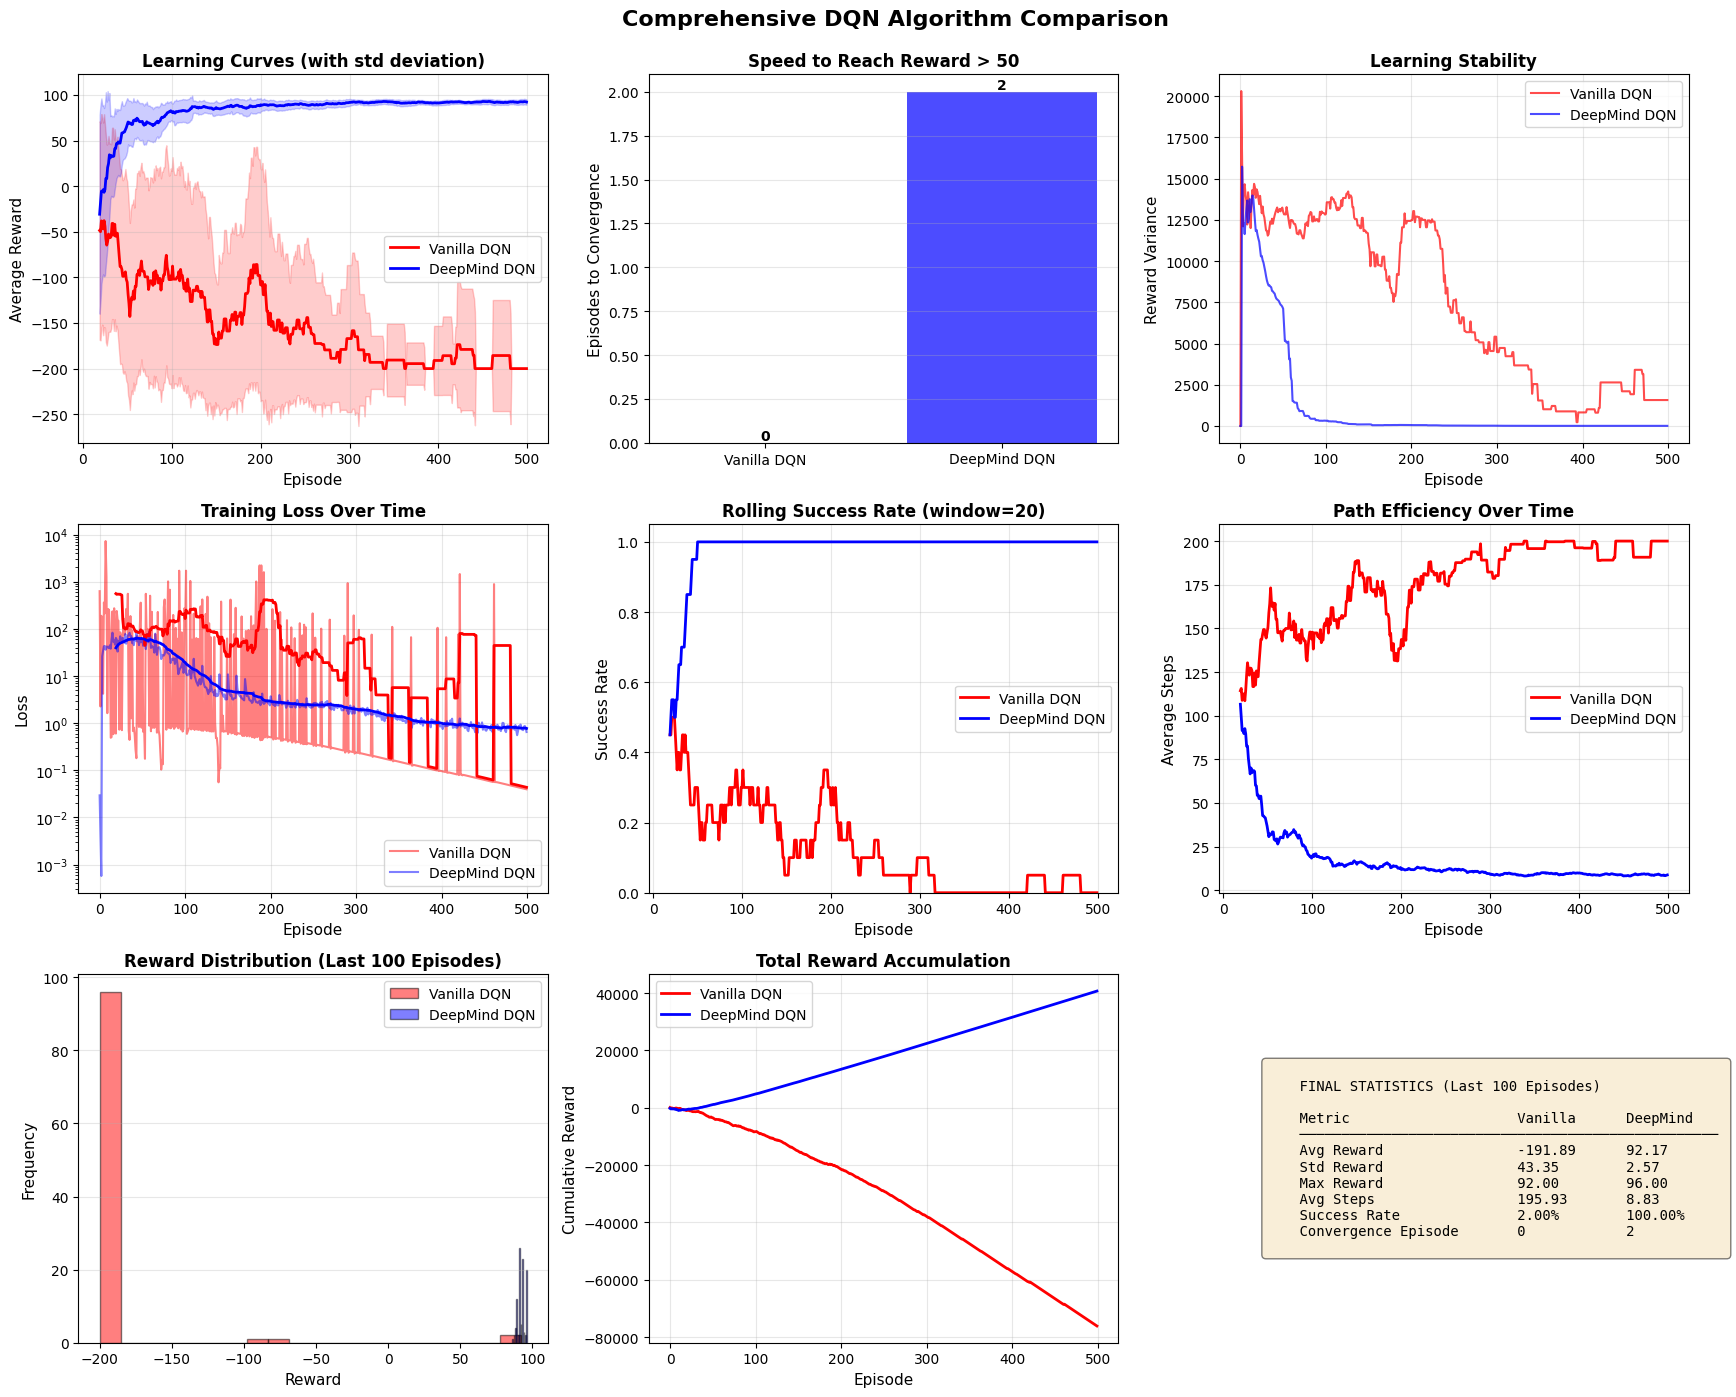


TESTING VANILLA_DQN
Target Goal: 2
Steps: 200, Total Reward: -200.00
Goal Reached: False
✓ Saved visualization as 'vanilla_dqn_test_path.png'


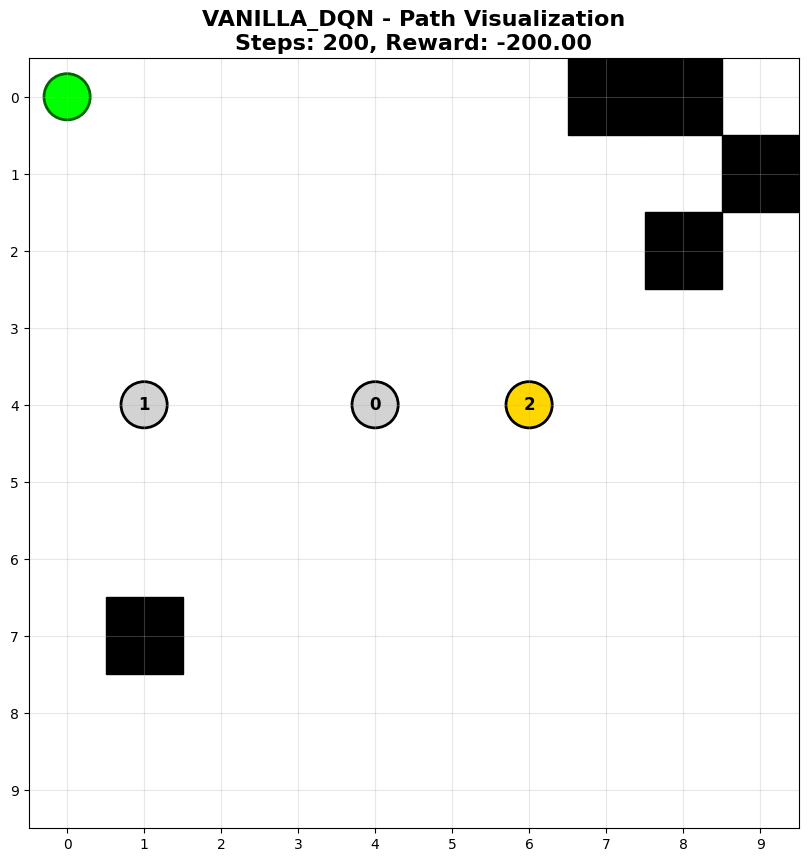


TESTING DEEPMIND_DQN
Target Goal: 1
Steps: 5, Total Reward: 96.00
Goal Reached: True
✓ Saved visualization as 'deepmind_dqn_test_path.png'


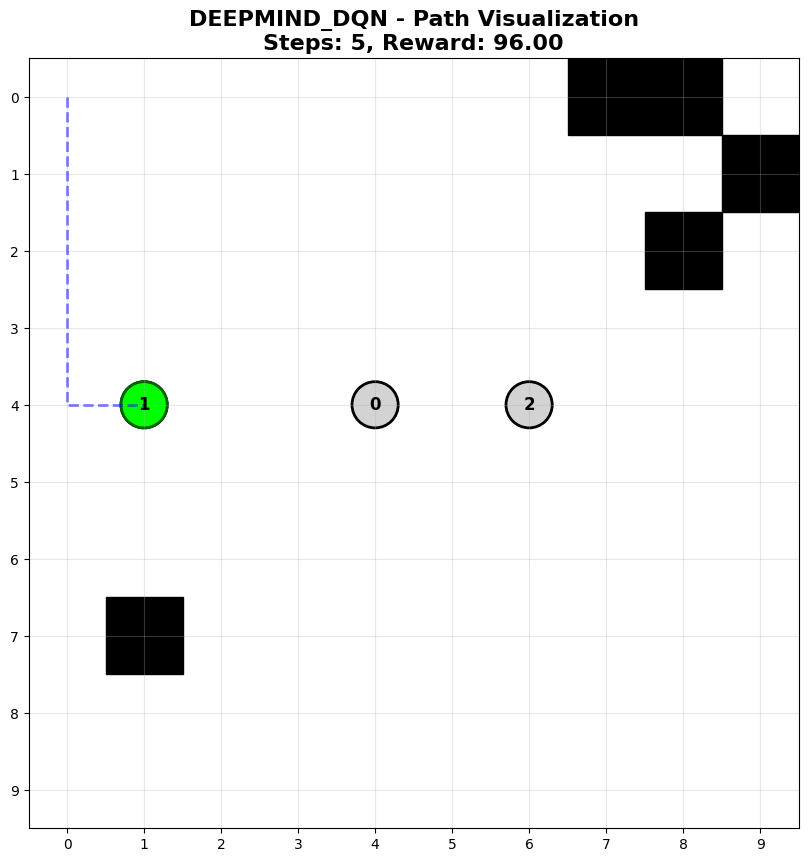

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import time


class MultiGoalGridWorld(gym.Env):
    """Custom GridWorld Environment compatible with Gymnasium"""
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 10):
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: [agent_x, agent_y, goal_x, goal_y]
        self.observation_space = spaces.Box(
            low=0, high=grid_size-1, shape=(4,), dtype=np.float32
        )

        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))
        selected_indices = np.random.choice(
            len(available_positions), size=total_needed, replace=False
        )

        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        return any(np.array_equal(pos, obs) for obs in self.obstacles)

    def _get_obs(self):
        target_pos = self.goals[self.target_goal]
        return np.concatenate([self.agent_pos, target_pos]).astype(np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.agent_pos = np.array([0, 0])

        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self._get_obs(), {}

    def step(self, action: int):
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        new_pos = self.agent_pos + direction_map[action]
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0
            terminated = False

        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            path_array = np.array([p[:2] for p in agent_path])
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2)

        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GridWorld - Target Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        return ax


# ============================================================================
# VANILLA DQN (Pre-DeepMind Improvements)
# ============================================================================

class VanillaQNetwork(nn.Module):
    """Simple Q-Network without modern improvements"""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 64):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return self.fc2(x)


class VanillaDQNAgent:
    """Vanilla DQN without target network, replay buffer, etc."""
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.001,
                 discount_factor: float = 0.95, epsilon: float = 1.0,
                 epsilon_decay: float = 0.995, epsilon_min: float = 0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.q_network = VanillaQNetwork(state_size, action_size)
        self.optimizer = optim.SGD(self.q_network.parameters(), lr=learning_rate)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        """Online learning - update after each step"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        # Current Q-value
        q_values = self.q_network(state_tensor)
        q_value = q_values[0, action]

        # Target Q-value (bootstrap from same network)
        with torch.no_grad():
            next_q_values = self.q_network(next_state_tensor)
            target = reward + (1 - done) * self.gamma * next_q_values.max().item()

        # Loss and update
        loss = nn.MSELoss()(q_value, torch.tensor(target))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# ============================================================================
# DEEPMIND DQN (With Improvements)
# ============================================================================

class ReplayBuffer:
    """Experience Replay Buffer"""
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class DeepMindQNetwork(nn.Module):
    """Deeper Q-Network with more capacity"""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DeepMindDQNAgent:
    """DQN with DeepMind improvements: Target Network, Replay Buffer, Batch Updates"""
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0005,
                 discount_factor: float = 0.95, epsilon: float = 1.0,
                 epsilon_decay: float = 0.995, epsilon_min: float = 0.01,
                 buffer_size: int = 10000, batch_size: int = 64):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        # Main and Target Networks
        self.q_network = DeepMindQNetwork(state_size, action_size)
        self.target_network = DeepMindQNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update(self):
        """Batch learning with target network"""
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_vanilla_dqn(env, episodes=1000):
    """Train Vanilla DQN (Pre-DeepMind)"""
    agent = VanillaDQNAgent(
        state_size=4,
        action_size=env.action_space.n,
        learning_rate=0.001,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )

    episode_rewards = []
    episode_steps = []
    episode_losses = []

    print("\n" + "="*70)
    print("TRAINING VANILLA DQN (Pre-DeepMind)")
    print("="*70)

    for episode in range(episodes):
        env.target_goal = np.random.randint(0, env.num_goals)
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            loss = agent.update(state, action, reward, next_state, done)
            episode_loss += loss
            loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / loss_count)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

    return agent, episode_rewards, episode_steps, episode_losses


def train_deepmind_dqn(env, episodes=1000):
    """Train DeepMind DQN (With Improvements)"""
    agent = DeepMindDQNAgent(
        state_size=4,
        action_size=env.action_space.n,
        learning_rate=0.0005,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=64
    )

    episode_rewards = []
    episode_steps = []
    episode_losses = []

    print("\n" + "="*70)
    print("TRAINING DEEPMIND DQN (With Target Network + Replay Buffer)")
    print("="*70)

    target_update_freq = 10
    for episode in range(episodes):
        env.target_goal = np.random.randint(0, env.num_goals)
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.update()

            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

    return agent, episode_rewards, episode_steps, episode_losses


class MetricsCallback(BaseCallback):
    """Callback to track training metrics for Stable-Baselines3"""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_steps = []
        self.current_episode_reward = 0
        self.current_episode_steps = 0

    def _on_step(self):
        self.current_episode_reward += self.locals['rewards'][0]
        self.current_episode_steps += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_steps.append(self.current_episode_steps)
            self.current_episode_reward = 0
            self.current_episode_steps = 0
        return True


def train_sb3_dqn(env, total_timesteps=100000):
    """Train using Stable-Baselines3 DQN"""
    print("\n" + "="*70)
    print("TRAINING STABLE-BASELINES3 DQN (Modern Implementation)")
    print("="*70)

    env = Monitor(env)
    callback = MetricsCallback()

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=0.0005,
        buffer_size=10000,
        learning_starts=1000,
        batch_size=64,
        gamma=0.95,
        train_freq=4,
        target_update_interval=1000,
        exploration_fraction=0.5,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.01,
        verbose=1
    )

    model.learn(total_timesteps=total_timesteps, callback=callback)

    return model, callback.episode_rewards, callback.episode_steps


# ============================================================================
# COMPARISON AND VISUALIZATION
# ============================================================================

def compare_algorithms():
    """Compare all three DQN implementations"""

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=10,
        target_goal=0,
        num_goals=3,
        num_obstacles=5
    )

    episodes = 1000

    # Train all three algorithms
    start_time = time.time()
    vanilla_agent, vanilla_rewards, vanilla_steps, vanilla_losses = train_vanilla_dqn(env, episodes)
    vanilla_time = time.time() - start_time

    start_time = time.time()
    deepmind_agent, deepmind_rewards, deepmind_steps, deepmind_losses = train_deepmind_dqn(env, episodes)
    deepmind_time = time.time() - start_time

    start_time = time.time()
    sb3_model, sb3_rewards, sb3_steps = train_sb3_dqn(env, total_timesteps=episodes * 50)
    sb3_time = time.time() - start_time

    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Rewards Comparison
    ax1 = plt.subplot(2, 3, 1)
    window = 50
    ax1.plot(vanilla_rewards, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_rewards) >= window:
        moving_avg = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(vanilla_rewards)), moving_avg, color='red', linewidth=2)

    ax1.plot(deepmind_rewards, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_rewards) >= window:
        moving_avg = np.convolve(deepmind_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(deepmind_rewards)), moving_avg, color='blue', linewidth=2)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Rewards Comparison', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Steps Comparison
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(vanilla_steps, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_steps) >= window:
        moving_avg = np.convolve(vanilla_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(vanilla_steps)), moving_avg, color='red', linewidth=2)

    ax2.plot(deepmind_steps, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_steps) >= window:
        moving_avg = np.convolve(deepmind_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(deepmind_steps)), moving_avg, color='blue', linewidth=2)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps to Goal')
    ax2.set_title('Steps Comparison', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Loss Comparison
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(vanilla_losses, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_losses) >= window:
        moving_avg = np.convolve(vanilla_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(vanilla_losses)), moving_avg, color='red', linewidth=2)

    ax3.plot(deepmind_losses, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_losses) >= window:
        moving_avg = np.convolve(deepmind_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(deepmind_losses)), moving_avg, color='blue', linewidth=2)

    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss Comparison', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: SB3 Rewards
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(sb3_rewards, alpha=0.5, color='green')
    if len(sb3_rewards) >= window:
        moving_avg = np.convolve(sb3_rewards, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(sb3_rewards)), moving_avg, color='darkgreen', linewidth=2)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Total Reward')
    ax4.set_title('Stable-Baselines3 DQN Rewards', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Performance Summary
    ax5 = plt.subplot(2, 3, 5)
    final_rewards = [
        np.mean(vanilla_rewards[-100:]),
        np.mean(deepmind_rewards[-100:]),
        np.mean(sb3_rewards[-100:]) if len(sb3_rewards) >= 100 else np.mean(sb3_rewards)
    ]
    algorithms = ['Vanilla\nDQN', 'DeepMind\nDQN', 'SB3\nDQN']
    colors = ['red', 'blue', 'green']
    bars = ax5.bar(algorithms, final_rewards, color=colors, alpha=0.7)
    ax5.set_ylabel('Average Reward (Last 100 Episodes)')
    ax5.set_title('Final Performance Comparison', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    for bar, reward in zip(bars, final_rewards):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{reward:.1f}', ha='center', va='bottom', fontweight='bold')

    # Plot 6: Training Time Comparison
    ax6 = plt.subplot(2, 3, 6)
    times = [vanilla_time, deepmind_time, sb3_time]
    bars = ax6.bar(algorithms, times, color=colors, alpha=0.7)
    ax6.set_ylabel('Training Time (seconds)')
    ax6.set_title('Training Time Comparison', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    for bar, t in zip(bars, times):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('dqn_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Comparison plot saved as 'dqn_comparison.png'")
    plt.show()

    # Print summary
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    print(f"\n{'Algorithm':<25} {'Avg Reward':<15} {'Avg Steps':<15} {'Time (s)':<15}")
    print("-" * 70)
    print(f"{'Vanilla DQN':<25} {np.mean(vanilla_rewards[-100:]):<15.2f} {np.mean(vanilla_steps[-100:]):<15.2f} {vanilla_time:<15.2f}")
    print(f"{'DeepMind DQN':<25} {np.mean(deepmind_rewards[-100:]):<15.2f} {np.mean(deepmind_steps[-100:]):<15.2f} {deepmind_time:<15.2f}")
    print(f"{'Stable-Baselines3 DQN':<25} {np.mean(sb3_rewards[-100:]) if len(sb3_rewards) >= 100 else np.mean(sb3_rewards):<15.2f} {np.mean(sb3_steps[-100:]) if len(sb3_steps) >= 100 else np.mean(sb3_steps):<15.2f} {sb3_time:<15.2f}")
    print("="*70)

    print("\nKey Improvements in DeepMind DQN:")
    print("  1. Experience Replay Buffer - breaks correlation in sequential data")
    print("  2. Target Network - stabilizes learning by fixing targets")
    print("  3. Batch Updates - more stable gradient estimates")
    print("  4. Adam Optimizer - adaptive learning rates")
    print("  5. Deeper Network - more representational capacity")

    print("\nStable-Baselines3 Additional Features:")
    print("  - Optimized implementation with extensive testing")
    print("  - Learning rate scheduling")
    print("  - Gradient clipping")
    print("  - Polyak averaging for target updates")
    print("  - Better exploration strategies")
    print("  - Logging and monitoring tools")

    return vanilla_agent, deepmind_agent, sb3_model


def test_agent(agent, env, agent_type="agent"):
    """Test a trained agent and visualize its performance"""
    print(f"\n{'='*70}")
    print(f"TESTING {agent_type.upper()}")
    print(f"{'='*70}")

    env.target_goal = np.random.randint(0, env.num_goals)
    print(f"Target Goal: {env.target_goal}")

    state, _ = env.reset()
    done = False
    steps = 0
    total_reward = 0
    agent_path = [state.copy()]

    while not done and steps < 200:
        if agent_type == "sb3":
            action, _ = agent.predict(state, deterministic=True)
        elif hasattr(agent, 'get_action'):
            old_epsilon = agent.epsilon
            agent.epsilon = 0  # Greedy policy
            action = agent.get_action(state)
            agent.epsilon = old_epsilon
        else:
            action = agent.get_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        state = next_state
        total_reward += reward
        steps += 1

    print(f"Steps: {steps}, Total Reward: {total_reward:.2f}")
    print(f"Goal Reached: {done}")

    # Visualize the path
    fig, ax = plt.subplots(figsize=(10, 10))
    env.render_grid(ax, agent_path=agent_path, current_step=steps)
    plt.title(f'{agent_type.upper()} - Path Visualization\nSteps: {steps}, Reward: {total_reward:.2f}',
              fontsize=16, fontweight='bold')
    filename = f'{agent_type}_test_path.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Saved visualization as '{filename}'")
    plt.show()

    return steps, total_reward


def detailed_comparison_visualization():
    """Create detailed visualizations showing the differences between algorithms"""

    print("\n" + "="*70)
    print("DETAILED ALGORITHM COMPARISON")
    print("="*70)

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=10,
        target_goal=0,
        num_goals=3,
        num_obstacles=5
    )

    # Train with fewer episodes for quick comparison
    episodes = 500

    print("\nTraining all algorithms...")
    vanilla_agent, vanilla_rewards, vanilla_steps, vanilla_losses = train_vanilla_dqn(env, episodes)
    deepmind_agent, deepmind_rewards, deepmind_steps, deepmind_losses = train_deepmind_dqn(env, episodes)

    # Create detailed comparison figure
    fig = plt.figure(figsize=(18, 14))

    # 1. Learning Curves with Statistical Bands
    ax1 = plt.subplot(3, 3, 1)
    window = 20

    # Vanilla DQN
    vanilla_mean = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')
    vanilla_std = np.array([np.std(vanilla_rewards[max(0,i-window):i+1])
                            for i in range(window-1, len(vanilla_rewards))])
    x_vanilla = range(window-1, len(vanilla_rewards))
    ax1.plot(x_vanilla, vanilla_mean, 'r-', linewidth=2, label='Vanilla DQN')
    ax1.fill_between(x_vanilla, vanilla_mean - vanilla_std, vanilla_mean + vanilla_std,
                     color='red', alpha=0.2)

    # DeepMind DQN
    deepmind_mean = np.convolve(deepmind_rewards, np.ones(window)/window, mode='valid')
    deepmind_std = np.array([np.std(deepmind_rewards[max(0,i-window):i+1])
                             for i in range(window-1, len(deepmind_rewards))])
    x_deepmind = range(window-1, len(deepmind_rewards))
    ax1.plot(x_deepmind, deepmind_mean, 'b-', linewidth=2, label='DeepMind DQN')
    ax1.fill_between(x_deepmind, deepmind_mean - deepmind_std, deepmind_mean + deepmind_std,
                     color='blue', alpha=0.2)

    ax1.set_xlabel('Episode', fontsize=11)
    ax1.set_ylabel('Average Reward', fontsize=11)
    ax1.set_title('Learning Curves (with std deviation)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Convergence Speed
    ax2 = plt.subplot(3, 3, 2)
    target_reward = 50  # Threshold for "good" performance
    vanilla_convergence = next((i for i, r in enumerate(vanilla_rewards) if r > target_reward), episodes)
    deepmind_convergence = next((i for i, r in enumerate(deepmind_rewards) if r > target_reward), episodes)

    bars = ax2.bar(['Vanilla DQN', 'DeepMind DQN'],
                   [vanilla_convergence, deepmind_convergence],
                   color=['red', 'blue'], alpha=0.7)
    ax2.set_ylabel('Episodes to Convergence', fontsize=11)
    ax2.set_title(f'Speed to Reach Reward > {target_reward}', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # 3. Stability Analysis (Variance over time)
    ax3 = plt.subplot(3, 3, 3)
    window_size = 50
    vanilla_variance = [np.var(vanilla_rewards[max(0,i-window_size):i+1])
                       for i in range(len(vanilla_rewards))]
    deepmind_variance = [np.var(deepmind_rewards[max(0,i-window_size):i+1])
                        for i in range(len(deepmind_rewards))]

    ax3.plot(vanilla_variance, 'r-', alpha=0.7, label='Vanilla DQN')
    ax3.plot(deepmind_variance, 'b-', alpha=0.7, label='DeepMind DQN')
    ax3.set_xlabel('Episode', fontsize=11)
    ax3.set_ylabel('Reward Variance', fontsize=11)
    ax3.set_title('Learning Stability', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Loss Progression
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(vanilla_losses, 'r-', alpha=0.5, label='Vanilla DQN')
    ax4.plot(deepmind_losses, 'b-', alpha=0.5, label='DeepMind DQN')

    # Add smoothed versions
    if len(vanilla_losses) >= window:
        vanilla_loss_smooth = np.convolve(vanilla_losses, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(vanilla_losses)), vanilla_loss_smooth, 'r-', linewidth=2)
    if len(deepmind_losses) >= window:
        deepmind_loss_smooth = np.convolve(deepmind_losses, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(deepmind_losses)), deepmind_loss_smooth, 'b-', linewidth=2)

    ax4.set_xlabel('Episode', fontsize=11)
    ax4.set_ylabel('Loss', fontsize=11)
    ax4.set_title('Training Loss Over Time', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # 5. Success Rate
    ax5 = plt.subplot(3, 3, 5)
    vanilla_success = [1 if r > 0 else 0 for r in vanilla_rewards]
    deepmind_success = [1 if r > 0 else 0 for r in deepmind_rewards]

    vanilla_success_rate = np.convolve(vanilla_success, np.ones(window)/window, mode='valid')
    deepmind_success_rate = np.convolve(deepmind_success, np.ones(window)/window, mode='valid')

    ax5.plot(range(window-1, len(vanilla_rewards)), vanilla_success_rate, 'r-', linewidth=2, label='Vanilla DQN')
    ax5.plot(range(window-1, len(deepmind_rewards)), deepmind_success_rate, 'b-', linewidth=2, label='DeepMind DQN')
    ax5.set_xlabel('Episode', fontsize=11)
    ax5.set_ylabel('Success Rate', fontsize=11)
    ax5.set_title(f'Rolling Success Rate (window={window})', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim([0, 1.05])

    # 6. Steps Efficiency
    ax6 = plt.subplot(3, 3, 6)
    vanilla_steps_smooth = np.convolve(vanilla_steps, np.ones(window)/window, mode='valid')
    deepmind_steps_smooth = np.convolve(deepmind_steps, np.ones(window)/window, mode='valid')

    ax6.plot(range(window-1, len(vanilla_steps)), vanilla_steps_smooth, 'r-', linewidth=2, label='Vanilla DQN')
    ax6.plot(range(window-1, len(deepmind_steps)), deepmind_steps_smooth, 'b-', linewidth=2, label='DeepMind DQN')
    ax6.set_xlabel('Episode', fontsize=11)
    ax6.set_ylabel('Average Steps', fontsize=11)
    ax6.set_title('Path Efficiency Over Time', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. Performance Distribution
    ax7 = plt.subplot(3, 3, 7)
    last_100_vanilla = vanilla_rewards[-100:]
    last_100_deepmind = deepmind_rewards[-100:]

    ax7.hist(last_100_vanilla, bins=20, alpha=0.5, color='red', label='Vanilla DQN', edgecolor='black')
    ax7.hist(last_100_deepmind, bins=20, alpha=0.5, color='blue', label='DeepMind DQN', edgecolor='black')
    ax7.set_xlabel('Reward', fontsize=11)
    ax7.set_ylabel('Frequency', fontsize=11)
    ax7.set_title('Reward Distribution (Last 100 Episodes)', fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3, axis='y')

    # 8. Cumulative Reward
    ax8 = plt.subplot(3, 3, 8)
    vanilla_cumulative = np.cumsum(vanilla_rewards)
    deepmind_cumulative = np.cumsum(deepmind_rewards)

    ax8.plot(vanilla_cumulative, 'r-', linewidth=2, label='Vanilla DQN')
    ax8.plot(deepmind_cumulative, 'b-', linewidth=2, label='DeepMind DQN')
    ax8.set_xlabel('Episode', fontsize=11)
    ax8.set_ylabel('Cumulative Reward', fontsize=11)
    ax8.set_title('Total Reward Accumulation', fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # 9. Final Statistics Table (as text)
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    stats_text = f"""
    FINAL STATISTICS (Last 100 Episodes)

    {'Metric':<25} {'Vanilla':<12} {'DeepMind':<12}
    {'─'*50}
    {'Avg Reward':<25} {np.mean(last_100_vanilla):<12.2f} {np.mean(last_100_deepmind):<12.2f}
    {'Std Reward':<25} {np.std(last_100_vanilla):<12.2f} {np.std(last_100_deepmind):<12.2f}
    {'Max Reward':<25} {np.max(last_100_vanilla):<12.2f} {np.max(last_100_deepmind):<12.2f}
    {'Avg Steps':<25} {np.mean(vanilla_steps[-100:]):<12.2f} {np.mean(deepmind_steps[-100:]):<12.2f}
    {'Success Rate':<25} {np.mean([1 if r>0 else 0 for r in last_100_vanilla]):<12.2%} {np.mean([1 if r>0 else 0 for r in last_100_deepmind]):<12.2%}
    {'Convergence Episode':<25} {vanilla_convergence:<12d} {deepmind_convergence:<12d}
    """

    ax9.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.suptitle('Comprehensive DQN Algorithm Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('detailed_dqn_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Detailed comparison saved as 'detailed_dqn_comparison.png'")
    plt.show()

    # Test both agents
    test_agent(vanilla_agent, env, "vanilla_dqn")
    test_agent(deepmind_agent, env, "deepmind_dqn")

    return vanilla_agent, deepmind_agent


if __name__ == "__main__":
    # Run full comparison
    vanilla_agent, deepmind_agent, sb3_model = compare_algorithms()

    # Run detailed visualization
    print("\n\nGenerating detailed comparison visualizations...")
    detailed_comparison_visualization()

Streaming output truncated to the last 5000 lines.
|    loss             | 0.287    |
|    n_updates        | 21607    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.12     |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 6076     |
|    fps              | 502      |
|    time_elapsed     | 174      |
|    total_timesteps  | 87462    |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.652    |
|    n_updates        | 21615    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.12     |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 6080     |
|    fps              | 502      |
|    time_elapsed     | 174      |
|   

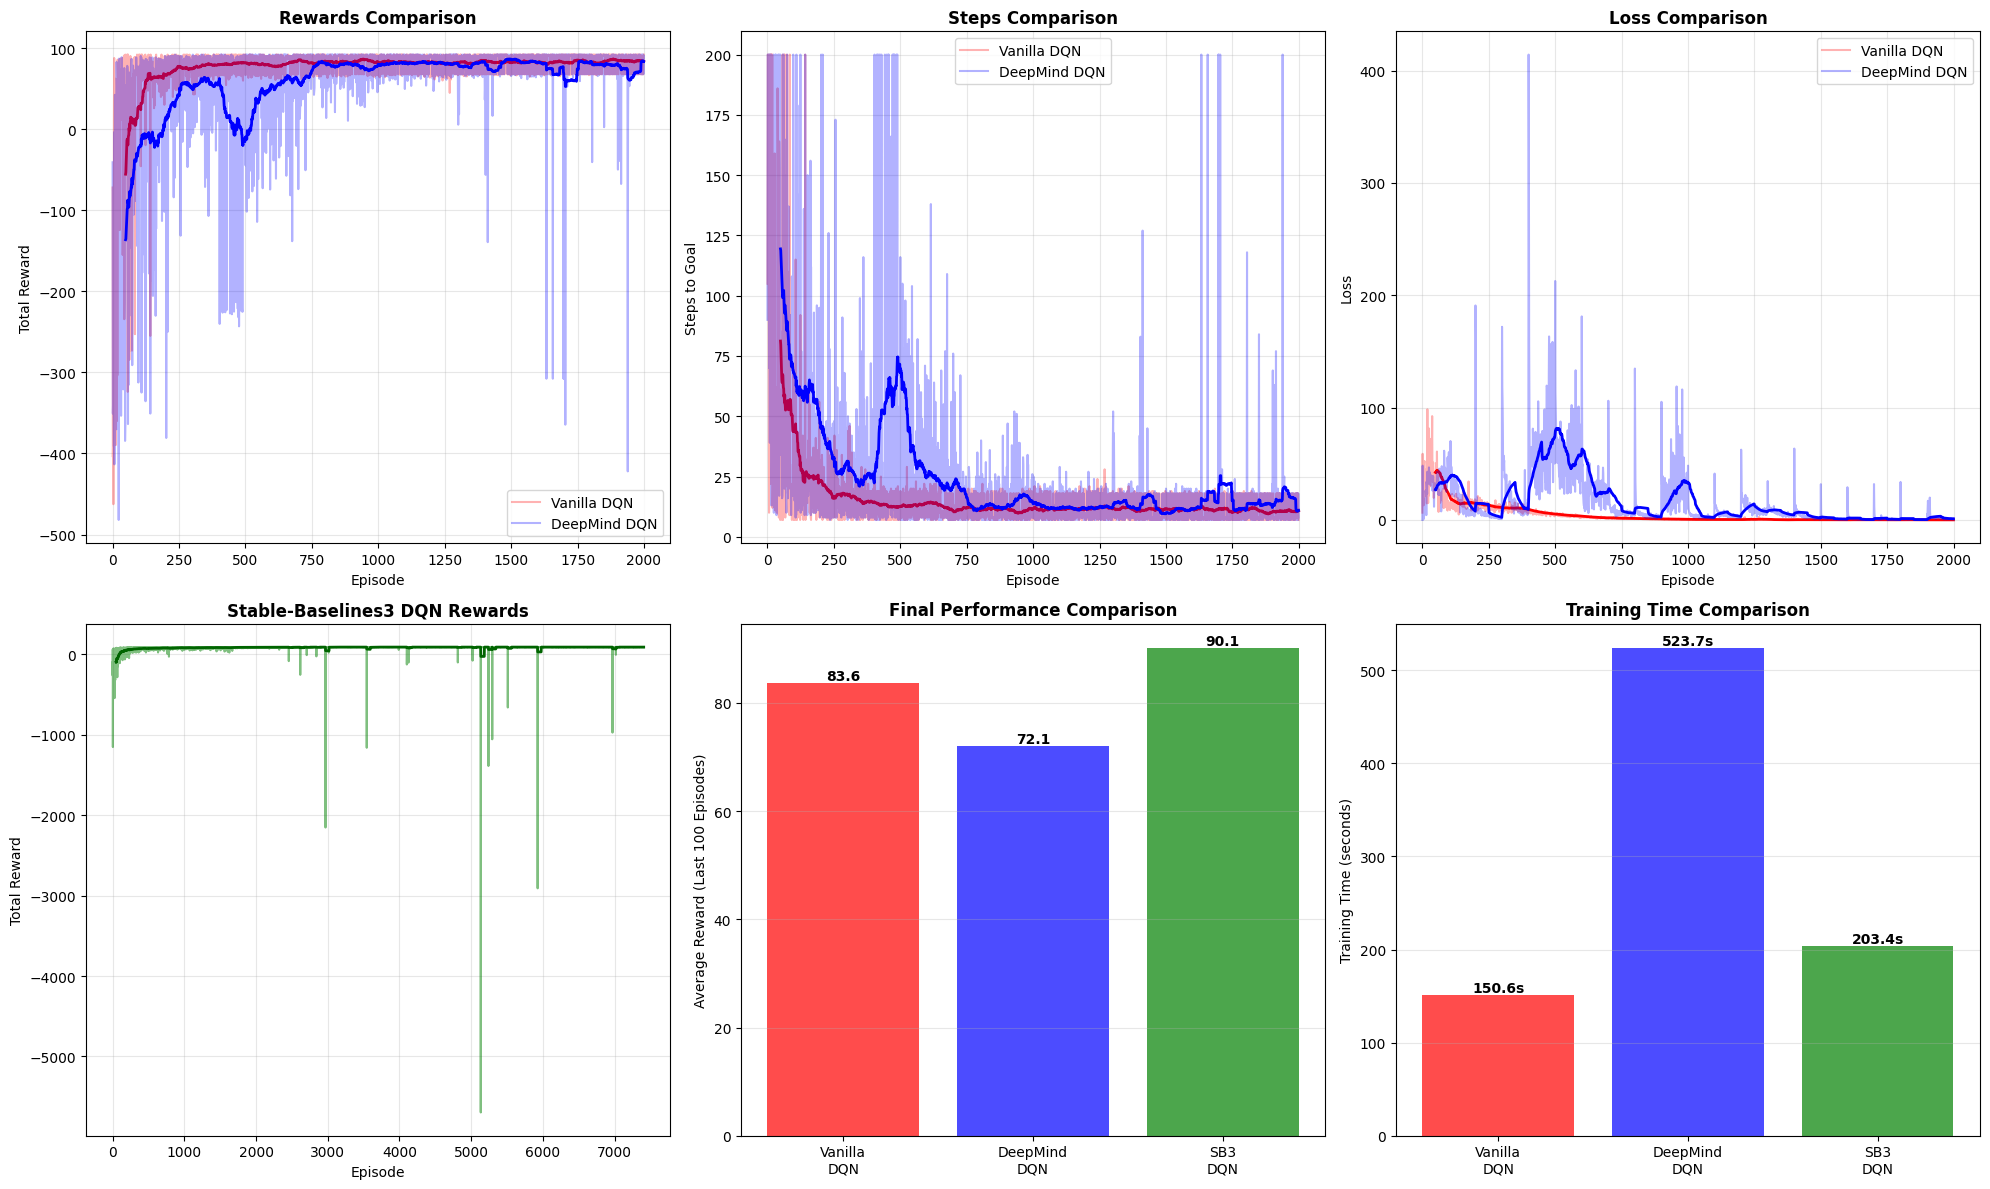


COMPARISON SUMMARY

Algorithm                 Avg Reward      Avg Steps       Time (s)       
----------------------------------------------------------------------
Vanilla DQN               83.59           10.85           150.64         
DeepMind DQN              72.06           15.75           523.70         
Stable-Baselines3 DQN     90.10           8.06            203.39         

Key Improvements in DeepMind DQN:
  1. Experience Replay Buffer - breaks correlation in sequential data
  2. Target Network - stabilizes learning by fixing targets
  3. Batch Updates - more stable gradient estimates
  4. Adam Optimizer - adaptive learning rates
  5. Deeper Network - more representational capacity
  6. Double DQN - reduces Q-value overestimation
  7. Gradient Clipping - improves training stability

Stable-Baselines3 Additional Features:
  - Optimized implementation with extensive testing
  - Learning rate scheduling
  - Gradient clipping
  - Polyak averaging for target updates
  - Better 

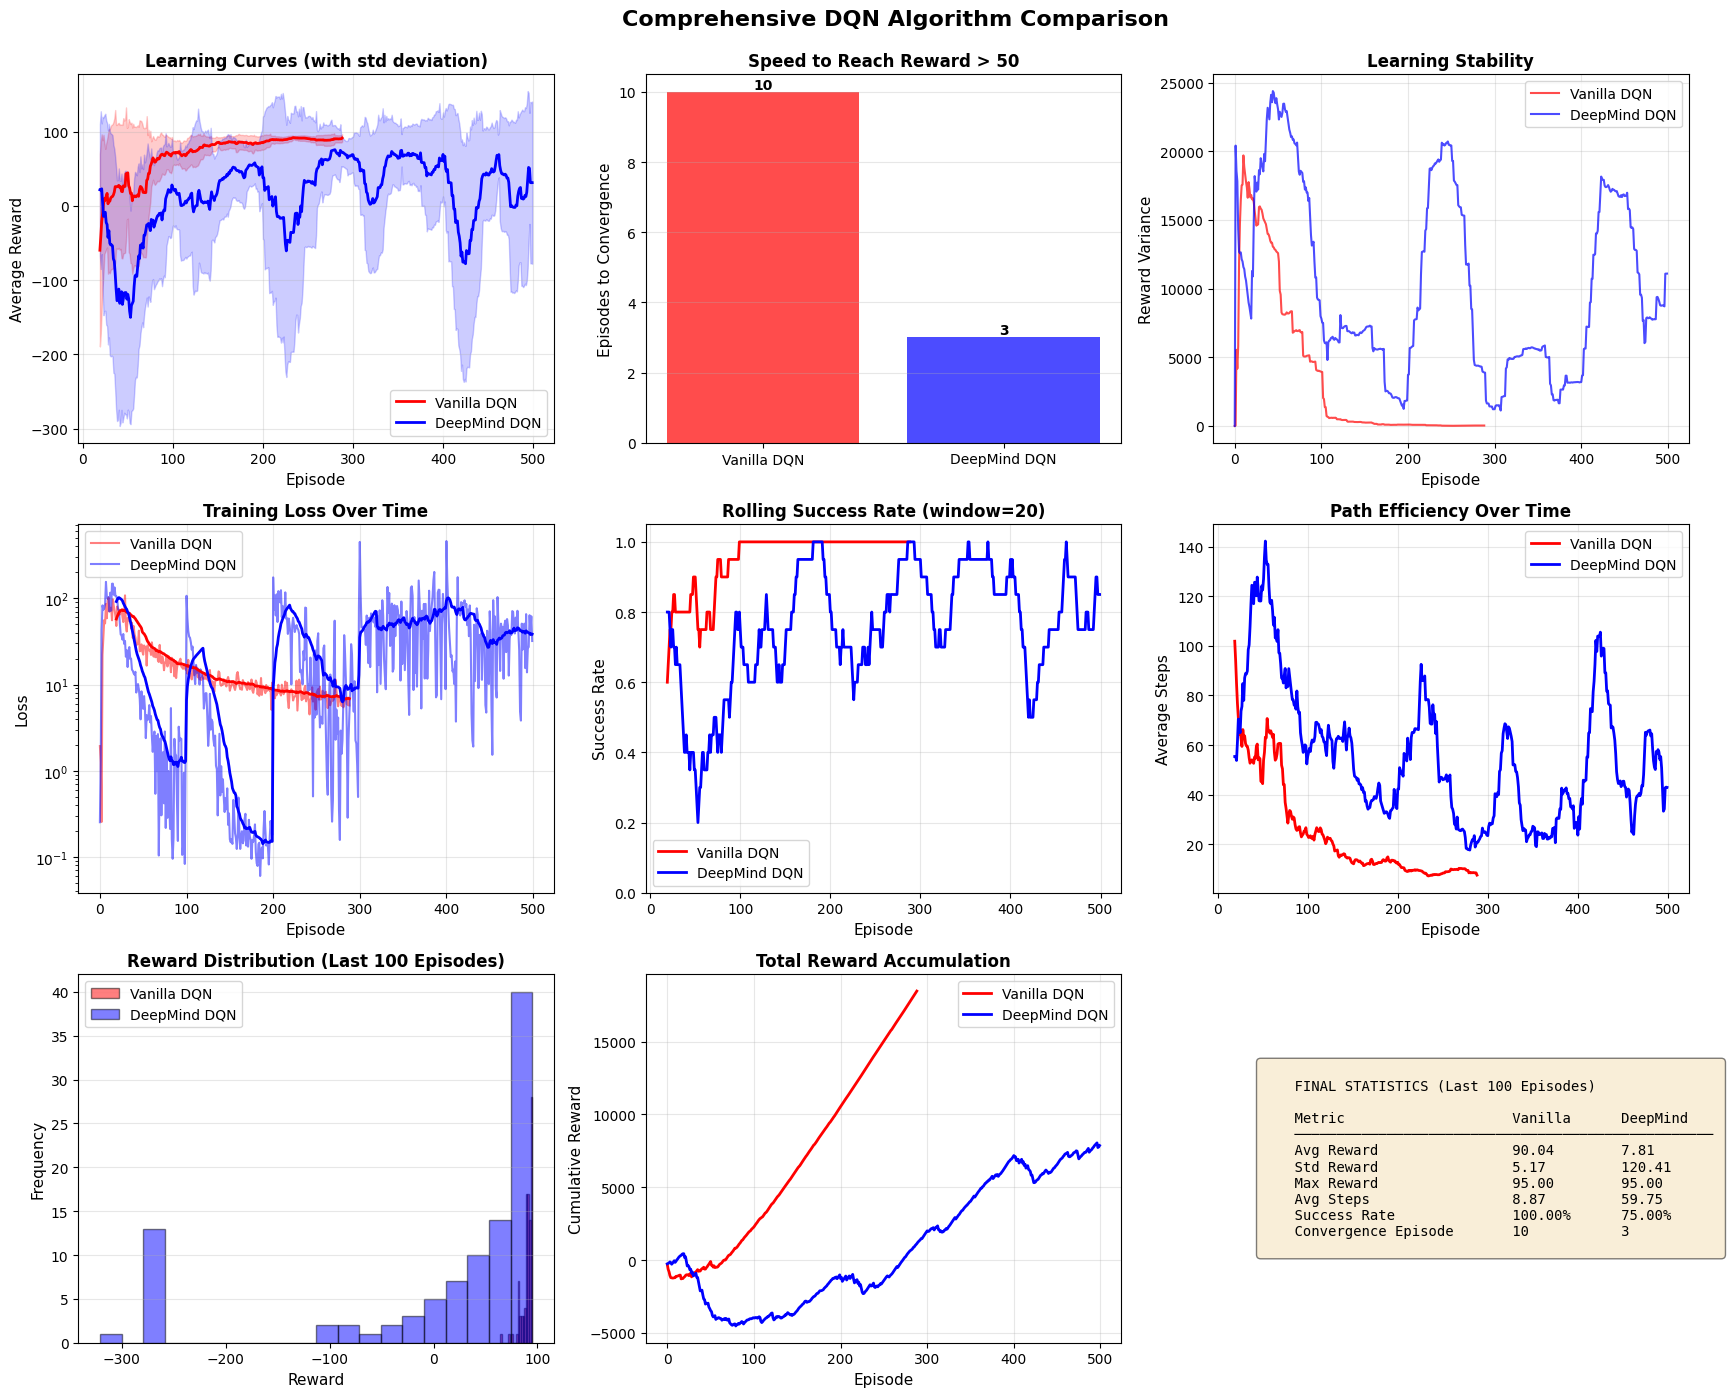


TESTING VANILLA_DQN
Target Goal: 2
Steps: 7, Total Reward: 91.90
Goal Reached: True
✓ Saved visualization as 'vanilla_dqn_test_path.png'


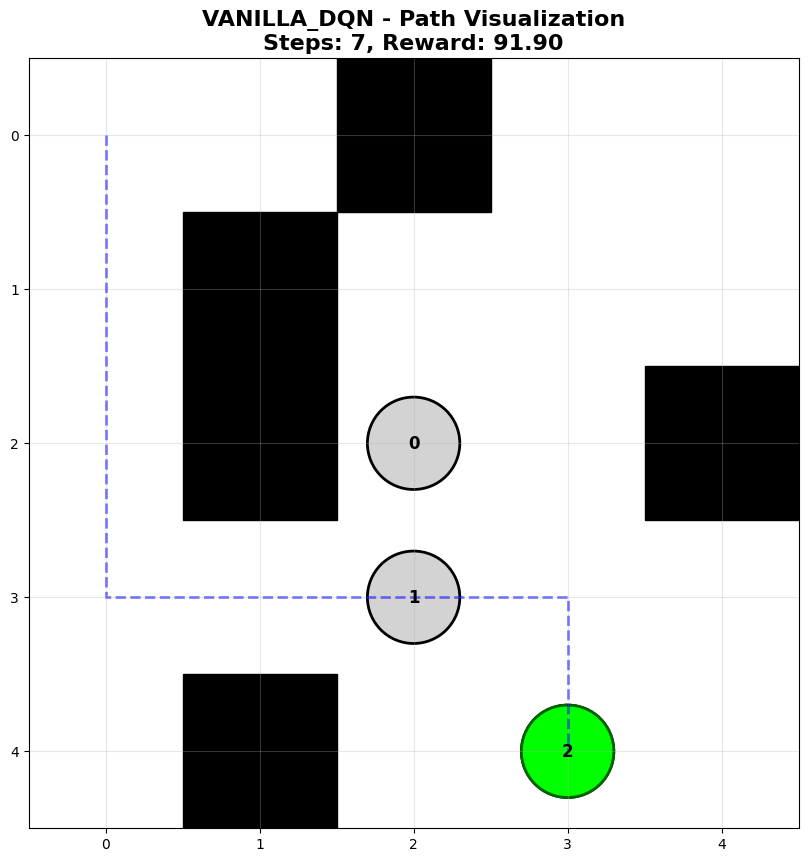


TESTING DEEPMIND_DQN
Target Goal: 0
Steps: 200, Total Reward: -280.00
Goal Reached: False
✓ Saved visualization as 'deepmind_dqn_test_path.png'


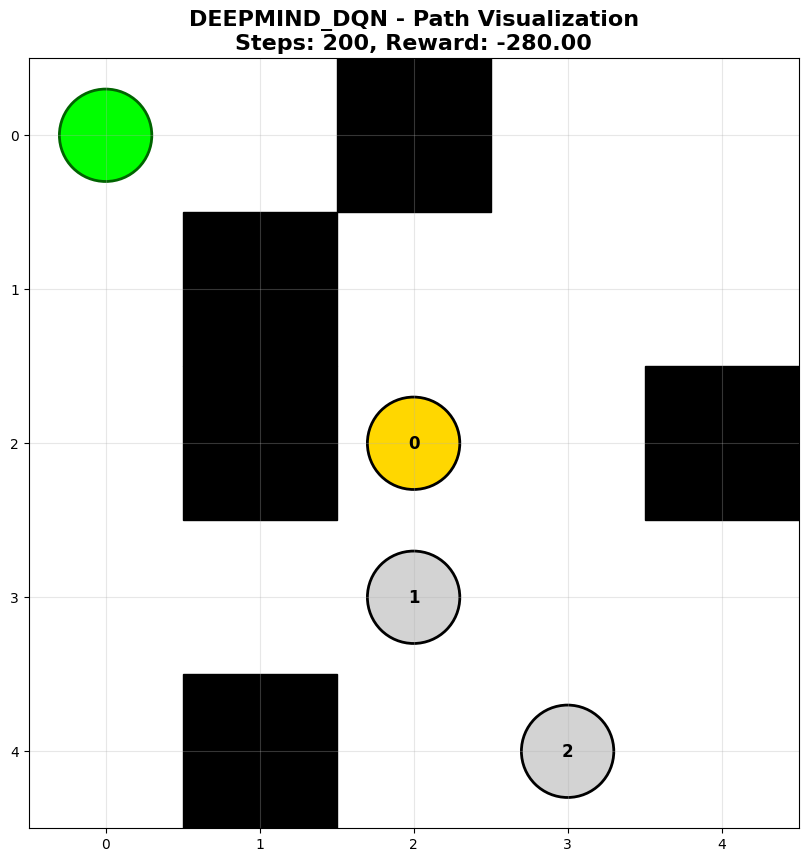

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import time


class MultiGoalGridWorld(gym.Env):
    """Custom GridWorld Environment compatible with Gymnasium"""
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 5):
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: [agent_x, agent_y, goal_x, goal_y]
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(4,), dtype=np.float32  # Normalized to [0, 1]
        )

        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))
        selected_indices = np.random.choice(
            len(available_positions), size=total_needed, replace=False
        )

        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        return any(np.array_equal(pos, obs) for obs in self.obstacles)

    def _get_obs(self):
        target_pos = self.goals[self.target_goal]
        # Normalize positions to [0, 1]
        normalized_state = np.concatenate([
            self.agent_pos / (self.grid_size - 1),
            target_pos / (self.grid_size - 1)
        ]).astype(np.float32)
        return normalized_state

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.agent_pos = np.array([0, 0])

        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self._get_obs(), {}

    def step(self, action: int):
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        new_pos = self.agent_pos + direction_map[action]
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        # Reward shaping: Manhattan distance-based penalty
        curr_distance = np.sum(np.abs(self.agent_pos - target_pos))
        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0 - 0.1 * curr_distance  # Penalize based on distance to goal
            terminated = False

        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            # Convert normalized path back to grid coordinates for visualization
            path_array = np.array([p[:2] * (self.grid_size - 1) for p in agent_path])
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2)

        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GridWorld - Target Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        return ax


# ============================================================================
# VANILLA DQN (Improved with Experience Replay)
# ============================================================================

class VanillaQNetwork(nn.Module):
    """Improved Q-Network with additional layer"""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    """Experience Replay Buffer"""
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class VanillaDQNAgent:
    """Improved Vanilla DQN with experience replay and Adam optimizer"""
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0005,
                 discount_factor: float = 0.99, epsilon: float = 1.0,
                 epsilon_decay: float = 0.999, epsilon_min: float = 0.01,
                 buffer_size: int = 10000, batch_size: int = 64):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.q_network = VanillaQNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray, temperature: float = 1.0) -> int:
        if np.random.random() < self.epsilon:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor).squeeze()
                probabilities = torch.softmax(q_values / temperature, dim=0).numpy()
            return np.random.choice(self.action_size, p=probabilities)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update(self):
        """Batch learning with replay buffer"""
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_q_values = self.q_network(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self, episode: int, total_episodes: int):
        self.epsilon = max(self.epsilon_min, 1.0 - (episode / total_episodes) * (1.0 - self.epsilon_min))


# ============================================================================
# DEEPMIND DQN (With Double DQN and Gradient Clipping)
# ============================================================================

class DeepMindQNetwork(nn.Module):
    """Deeper Q-Network with increased capacity"""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 256):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


class DeepMindDQNAgent:
    """DQN with DeepMind improvements: Target Network, Replay Buffer, Double DQN"""
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0005,
                 discount_factor: float = 0.99, epsilon: float = 1.0,
                 epsilon_decay: float = 0.999, epsilon_min: float = 0.01,
                 buffer_size: int = 10000, batch_size: int = 128):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        # Main and Target Networks
        self.q_network = DeepMindQNetwork(state_size, action_size)
        self.target_network = DeepMindQNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray, temperature: float = 1.0) -> int:
        if np.random.random() < self.epsilon:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor).squeeze()
                probabilities = torch.softmax(q_values / temperature, dim=0).numpy()
            return np.random.choice(self.action_size, p=probabilities)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update(self):
        """Batch learning with Double DQN and gradient clipping"""
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            # Double DQN: Use main network to select actions, target network to evaluate
            next_actions = self.q_network(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_network(next_states).gather(1, next_actions).squeeze(1)
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self, episode: int, total_episodes: int):
        self.epsilon = max(self.epsilon_min, 1.0 - (episode / total_episodes) * (1.0 - self.epsilon_min))


# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_vanilla_dqn(env, episodes=2000, early_stop_reward=90):
    """Train Improved Vanilla DQN"""
    agent = VanillaDQNAgent(
        state_size=4,
        action_size=env.action_space.n,
        learning_rate=0.0005,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=64
    )

    episode_rewards = []
    episode_steps = []
    episode_losses = []

    print("\n" + "="*70)
    print("TRAINING IMPROVED VANILLA DQN (With Experience Replay)")
    print("="*70)

    for episode in range(episodes):
        env.target_goal = np.random.randint(0, env.num_goals)
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:
            action = agent.get_action(state, temperature=1.0)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.update()

            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon(episode, episodes)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

        if episode >= 100 and np.mean(episode_rewards[-100:]) >= early_stop_reward:
            print(f"Early stopping at episode {episode + 1} with avg reward {np.mean(episode_rewards[-100:]):.2f}")
            break

    return agent, episode_rewards, episode_steps, episode_losses


def train_deepmind_dqn(env, episodes=2000, early_stop_reward=90):
    """Train Improved DeepMind DQN"""
    agent = DeepMindDQNAgent(
        state_size=4,
        action_size=env.action_space.n,
        learning_rate=0.0005,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=128
    )

    episode_rewards = []
    episode_steps = []
    episode_losses = []

    print("\n" + "="*70)
    print("TRAINING IMPROVED DEEPMIND DQN (With Double DQN + Gradient Clipping)")
    print("="*70)

    target_update_freq = 100
    for episode in range(episodes):
        env.target_goal = np.random.randint(0, env.num_goals)
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:
            action = agent.get_action(state, temperature=1.0)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.update()

            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        agent.decay_epsilon(episode, episodes)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

        if episode >= 100 and np.mean(episode_rewards[-100:]) >= early_stop_reward:
            print(f"Early stopping at episode {episode + 1} with avg reward {np.mean(episode_rewards[-100:]):.2f}")
            break

    return agent, episode_rewards, episode_steps, episode_losses


class MetricsCallback(BaseCallback):
    """Callback to track training metrics for Stable-Baselines3"""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_steps = []
        self.current_episode_reward = 0
        self.current_episode_steps = 0

    def _on_step(self):
        self.current_episode_reward += self.locals['rewards'][0]
        self.current_episode_steps += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_steps.append(self.current_episode_steps)
            self.current_episode_reward = 0
            self.current_episode_steps = 0
        return True


def train_sb3_dqn(env, total_timesteps=100000):
    """Train using Stable-Baselines3 DQN"""
    print("\n" + "="*70)
    print("TRAINING STABLE-BASELINES3 DQN (Modern Implementation)")
    print("="*70)

    env = Monitor(env)
    callback = MetricsCallback()

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=0.0005,
        buffer_size=10000,
        learning_starts=1000,
        batch_size=64,
        gamma=0.99,  # Updated to match other agents
        train_freq=4,
        target_update_interval=1000,
        exploration_fraction=0.5,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.01,
        verbose=1
    )

    model.learn(total_timesteps=total_timesteps, callback=callback)

    return model, callback.episode_rewards, callback.episode_steps


# ============================================================================
# COMPARISON AND VISUALIZATION
# ============================================================================

def compare_algorithms():
    """Compare all three DQN implementations"""

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=10,
        target_goal=0,
        num_goals=3,
        num_obstacles=5
    )

    episodes = 2000

    # Train all three algorithms
    start_time = time.time()
    vanilla_agent, vanilla_rewards, vanilla_steps, vanilla_losses = train_vanilla_dqn(env, episodes)
    vanilla_time = time.time() - start_time

    start_time = time.time()
    deepmind_agent, deepmind_rewards, deepmind_steps, deepmind_losses = train_deepmind_dqn(env, episodes)
    deepmind_time = time.time() - start_time

    start_time = time.time()
    sb3_model, sb3_rewards, sb3_steps = train_sb3_dqn(env, total_timesteps=episodes * 50)
    sb3_time = time.time() - start_time

    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Rewards Comparison
    ax1 = plt.subplot(2, 3, 1)
    window = 50
    ax1.plot(vanilla_rewards, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_rewards) >= window:
        moving_avg = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(vanilla_rewards)), moving_avg, color='red', linewidth=2)

    ax1.plot(deepmind_rewards, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_rewards) >= window:
        moving_avg = np.convolve(deepmind_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(deepmind_rewards)), moving_avg, color='blue', linewidth=2)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Rewards Comparison', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Steps Comparison
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(vanilla_steps, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_steps) >= window:
        moving_avg = np.convolve(vanilla_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(vanilla_steps)), moving_avg, color='red', linewidth=2)

    ax2.plot(deepmind_steps, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_steps) >= window:
        moving_avg = np.convolve(deepmind_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(deepmind_steps)), moving_avg, color='blue', linewidth=2)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps to Goal')
    ax2.set_title('Steps Comparison', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Loss Comparison
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(vanilla_losses, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_losses) >= window:
        moving_avg = np.convolve(vanilla_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(vanilla_losses)), moving_avg, color='red', linewidth=2)

    ax3.plot(deepmind_losses, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_losses) >= window:
        moving_avg = np.convolve(deepmind_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(deepmind_losses)), moving_avg, color='blue', linewidth=2)

    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss Comparison', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: SB3 Rewards
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(sb3_rewards, alpha=0.5, color='green')
    if len(sb3_rewards) >= window:
        moving_avg = np.convolve(sb3_rewards, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(sb3_rewards)), moving_avg, color='darkgreen', linewidth=2)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Total Reward')
    ax4.set_title('Stable-Baselines3 DQN Rewards', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Performance Summary
    ax5 = plt.subplot(2, 3, 5)
    final_rewards = [
        np.mean(vanilla_rewards[-100:]),
        np.mean(deepmind_rewards[-100:]),
        np.mean(sb3_rewards[-100:]) if len(sb3_rewards) >= 100 else np.mean(sb3_rewards)
    ]
    algorithms = ['Vanilla\nDQN', 'DeepMind\nDQN', 'SB3\nDQN']
    colors = ['red', 'blue', 'green']
    bars = ax5.bar(algorithms, final_rewards, color=colors, alpha=0.7)
    ax5.set_ylabel('Average Reward (Last 100 Episodes)')
    ax5.set_title('Final Performance Comparison', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    for bar, reward in zip(bars, final_rewards):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{reward:.1f}', ha='center', va='bottom', fontweight='bold')

    # Plot 6: Training Time Comparison
    ax6 = plt.subplot(2, 3, 6)
    times = [vanilla_time, deepmind_time, sb3_time]
    bars = ax6.bar(algorithms, times, color=colors, alpha=0.7)
    ax6.set_ylabel('Training Time (seconds)')
    ax6.set_title('Training Time Comparison', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    for bar, t in zip(bars, times):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('dqn_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Comparison plot saved as 'dqn_comparison.png'")
    plt.show()

    # Print summary
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    print(f"\n{'Algorithm':<25} {'Avg Reward':<15} {'Avg Steps':<15} {'Time (s)':<15}")
    print("-" * 70)
    print(f"{'Vanilla DQN':<25} {np.mean(vanilla_rewards[-100:]):<15.2f} {np.mean(vanilla_steps[-100:]):<15.2f} {vanilla_time:<15.2f}")
    print(f"{'DeepMind DQN':<25} {np.mean(deepmind_rewards[-100:]):<15.2f} {np.mean(deepmind_steps[-100:]):<15.2f} {deepmind_time:<15.2f}")
    print(f"{'Stable-Baselines3 DQN':<25} {np.mean(sb3_rewards[-100:]) if len(sb3_rewards) >= 100 else np.mean(sb3_rewards):<15.2f} {np.mean(sb3_steps[-100:]) if len(sb3_steps) >= 100 else np.mean(sb3_steps):<15.2f} {sb3_time:<15.2f}")
    print("="*70)

    print("\nKey Improvements in DeepMind DQN:")
    print("  1. Experience Replay Buffer - breaks correlation in sequential data")
    print("  2. Target Network - stabilizes learning by fixing targets")
    print("  3. Batch Updates - more stable gradient estimates")
    print("  4. Adam Optimizer - adaptive learning rates")
    print("  5. Deeper Network - more representational capacity")
    print("  6. Double DQN - reduces Q-value overestimation")
    print("  7. Gradient Clipping - improves training stability")

    print("\nStable-Baselines3 Additional Features:")
    print("  - Optimized implementation with extensive testing")
    print("  - Learning rate scheduling")
    print("  - Gradient clipping")
    print("  - Polyak averaging for target updates")
    print("  - Better exploration strategies")
    print("  - Logging and monitoring tools")

    return vanilla_agent, deepmind_agent, sb3_model


def test_agent(agent, env, agent_type="agent"):
    """Test a trained agent and visualize its performance"""
    print(f"\n{'='*70}")
    print(f"TESTING {agent_type.upper()}")
    print(f"{'='*70}")

    env.target_goal = np.random.randint(0, env.num_goals)
    print(f"Target Goal: {env.target_goal}")

    state, _ = env.reset()
    done = False
    steps = 0
    total_reward = 0
    agent_path = [state.copy()]

    while not done and steps < 200:
        if agent_type == "sb3":
            action, _ = agent.predict(state, deterministic=True)
        elif hasattr(agent, 'get_action'):
            old_epsilon = agent.epsilon
            agent.epsilon = 0  # Greedy policy
            action = agent.get_action(state, temperature=1.0)
            agent.epsilon = old_epsilon
        else:
            action = agent.get_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        state = next_state
        total_reward += reward
        steps += 1

    print(f"Steps: {steps}, Total Reward: {total_reward:.2f}")
    print(f"Goal Reached: {done}")

    # Visualize the path
    fig, ax = plt.subplots(figsize=(10, 10))
    env.render_grid(ax, agent_path=agent_path, current_step=steps)
    plt.title(f'{agent_type.upper()} - Path Visualization\nSteps: {steps}, Reward: {total_reward:.2f}',
              fontsize=16, fontweight='bold')
    filename = f'{agent_type}_test_path.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Saved visualization as '{filename}'")
    plt.show()

    return steps, total_reward


def detailed_comparison_visualization():
    """Create detailed visualizations showing the differences between algorithms"""

    print("\n" + "="*70)
    print("DETAILED ALGORITHM COMPARISON")
    print("="*70)

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=5,
        target_goal=0,
        num_goals=3,
        num_obstacles=5
    )

    # Train with fewer episodes for quick comparison
    episodes = 500

    print("\nTraining all algorithms...")
    vanilla_agent, vanilla_rewards, vanilla_steps, vanilla_losses = train_vanilla_dqn(env, episodes)
    deepmind_agent, deepmind_rewards, deepmind_steps, deepmind_losses = train_deepmind_dqn(env, episodes)

    # Create detailed comparison figure
    fig = plt.figure(figsize=(18, 14))

    # 1. Learning Curves with Statistical Bands
    ax1 = plt.subplot(3, 3, 1)
    window = 20

    # Vanilla DQN
    vanilla_mean = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')
    vanilla_std = np.array([np.std(vanilla_rewards[max(0,i-window):i+1])
                            for i in range(window-1, len(vanilla_rewards))])
    x_vanilla = range(window-1, len(vanilla_rewards))
    ax1.plot(x_vanilla, vanilla_mean, 'r-', linewidth=2, label='Vanilla DQN')
    ax1.fill_between(x_vanilla, vanilla_mean - vanilla_std, vanilla_mean + vanilla_std,
                     color='red', alpha=0.2)

    # DeepMind DQN
    deepmind_mean = np.convolve(deepmind_rewards, np.ones(window)/window, mode='valid')
    deepmind_std = np.array([np.std(deepmind_rewards[max(0,i-window):i+1])
                             for i in range(window-1, len(deepmind_rewards))])
    x_deepmind = range(window-1, len(deepmind_rewards))
    ax1.plot(x_deepmind, deepmind_mean, 'b-', linewidth=2, label='DeepMind DQN')
    ax1.fill_between(x_deepmind, deepmind_mean - deepmind_std, deepmind_mean + deepmind_std,
                     color='blue', alpha=0.2)

    ax1.set_xlabel('Episode', fontsize=11)
    ax1.set_ylabel('Average Reward', fontsize=11)
    ax1.set_title('Learning Curves (with std deviation)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Convergence Speed
    ax2 = plt.subplot(3, 3, 2)
    target_reward = 50  # Threshold for "good" performance
    vanilla_convergence = next((i for i, r in enumerate(vanilla_rewards) if r > target_reward), episodes)
    deepmind_convergence = next((i for i, r in enumerate(deepmind_rewards) if r > target_reward), episodes)

    bars = ax2.bar(['Vanilla DQN', 'DeepMind DQN'],
                   [vanilla_convergence, deepmind_convergence],
                   color=['red', 'blue'], alpha=0.7)
    ax2.set_ylabel('Episodes to Convergence', fontsize=11)
    ax2.set_title(f'Speed to Reach Reward > {target_reward}', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # 3. Stability Analysis (Variance over time)
    ax3 = plt.subplot(3, 3, 3)
    window_size = 50
    vanilla_variance = [np.var(vanilla_rewards[max(0,i-window_size):i+1])
                       for i in range(len(vanilla_rewards))]
    deepmind_variance = [np.var(deepmind_rewards[max(0,i-window_size):i+1])
                        for i in range(len(deepmind_rewards))]

    ax3.plot(vanilla_variance, 'r-', alpha=0.7, label='Vanilla DQN')
    ax3.plot(deepmind_variance, 'b-', alpha=0.7, label='DeepMind DQN')
    ax3.set_xlabel('Episode', fontsize=11)
    ax3.set_ylabel('Reward Variance', fontsize=11)
    ax3.set_title('Learning Stability', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Loss Progression
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(vanilla_losses, 'r-', alpha=0.5, label='Vanilla DQN')
    ax4.plot(deepmind_losses, 'b-', alpha=0.5, label='DeepMind DQN')

    # Add smoothed versions
    if len(vanilla_losses) >= window:
        vanilla_loss_smooth = np.convolve(vanilla_losses, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(vanilla_losses)), vanilla_loss_smooth, 'r-', linewidth=2)
    if len(deepmind_losses) >= window:
        deepmind_loss_smooth = np.convolve(deepmind_losses, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(deepmind_losses)), deepmind_loss_smooth, 'b-', linewidth=2)

    ax4.set_xlabel('Episode', fontsize=11)
    ax4.set_ylabel('Loss', fontsize=11)
    ax4.set_title('Training Loss Over Time', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # 5. Success Rate
    ax5 = plt.subplot(3, 3, 5)
    vanilla_success = [1 if r > 0 else 0 for r in vanilla_rewards]
    deepmind_success = [1 if r > 0 else 0 for r in deepmind_rewards]

    vanilla_success_rate = np.convolve(vanilla_success, np.ones(window)/window, mode='valid')
    deepmind_success_rate = np.convolve(deepmind_success, np.ones(window)/window, mode='valid')

    ax5.plot(range(window-1, len(vanilla_rewards)), vanilla_success_rate, 'r-', linewidth=2, label='Vanilla DQN')
    ax5.plot(range(window-1, len(deepmind_rewards)), deepmind_success_rate, 'b-', linewidth=2, label='DeepMind DQN')
    ax5.set_xlabel('Episode', fontsize=11)
    ax5.set_ylabel('Success Rate', fontsize=11)
    ax5.set_title(f'Rolling Success Rate (window={window})', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim([0, 1.05])

    # 6. Steps Efficiency
    ax6 = plt.subplot(3, 3, 6)
    vanilla_steps_smooth = np.convolve(vanilla_steps, np.ones(window)/window, mode='valid')
    deepmind_steps_smooth = np.convolve(deepmind_steps, np.ones(window)/window, mode='valid')

    ax6.plot(range(window-1, len(vanilla_steps)), vanilla_steps_smooth, 'r-', linewidth=2, label='Vanilla DQN')
    ax6.plot(range(window-1, len(deepmind_steps)), deepmind_steps_smooth, 'b-', linewidth=2, label='DeepMind DQN')
    ax6.set_xlabel('Episode', fontsize=11)
    ax6.set_ylabel('Average Steps', fontsize=11)
    ax6.set_title('Path Efficiency Over Time', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. Performance Distribution
    ax7 = plt.subplot(3, 3, 7)
    last_100_vanilla = vanilla_rewards[-100:]
    last_100_deepmind = deepmind_rewards[-100:]

    ax7.hist(last_100_vanilla, bins=20, alpha=0.5, color='red', label='Vanilla DQN', edgecolor='black')
    ax7.hist(last_100_deepmind, bins=20, alpha=0.5, color='blue', label='DeepMind DQN', edgecolor='black')
    ax7.set_xlabel('Reward', fontsize=11)
    ax7.set_ylabel('Frequency', fontsize=11)
    ax7.set_title('Reward Distribution (Last 100 Episodes)', fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3, axis='y')

    # 8. Cumulative Reward
    ax8 = plt.subplot(3, 3, 8)
    vanilla_cumulative = np.cumsum(vanilla_rewards)
    deepmind_cumulative = np.cumsum(deepmind_rewards)

    ax8.plot(vanilla_cumulative, 'r-', linewidth=2, label='Vanilla DQN')
    ax8.plot(deepmind_cumulative, 'b-', linewidth=2, label='DeepMind DQN')
    ax8.set_xlabel('Episode', fontsize=11)
    ax8.set_ylabel('Cumulative Reward', fontsize=11)
    ax8.set_title('Total Reward Accumulation', fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # 9. Final Statistics Table (as text)
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    stats_text = f"""
    FINAL STATISTICS (Last 100 Episodes)

    {'Metric':<25} {'Vanilla':<12} {'DeepMind':<12}
    {'─'*50}
    {'Avg Reward':<25} {np.mean(last_100_vanilla):<12.2f} {np.mean(last_100_deepmind):<12.2f}
    {'Std Reward':<25} {np.std(last_100_vanilla):<12.2f} {np.std(last_100_deepmind):<12.2f}
    {'Max Reward':<25} {np.max(last_100_vanilla):<12.2f} {np.max(last_100_deepmind):<12.2f}
    {'Avg Steps':<25} {np.mean(vanilla_steps[-100:]):<12.2f} {np.mean(deepmind_steps[-100:]):<12.2f}
    {'Success Rate':<25} {np.mean([1 if r>0 else 0 for r in last_100_vanilla]):<12.2%} {np.mean([1 if r>0 else 0 for r in last_100_deepmind]):<12.2%}
    {'Convergence Episode':<25} {vanilla_convergence:<12d} {deepmind_convergence:<12d}
    """

    ax9.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.suptitle('Comprehensive DQN Algorithm Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('detailed_dqn_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Detailed comparison saved as 'detailed_dqn_comparison.png'")
    plt.show()

    # Test both agents
    test_agent(vanilla_agent, env, "vanilla_dqn")
    test_agent(deepmind_agent, env, "deepmind_dqn")

    return vanilla_agent, deepmind_agent


if __name__ == "__main__":
    # Run full comparison
    vanilla_agent, deepmind_agent, sb3_model = compare_algorithms()

    # Run detailed visualization
    print("\n\nGenerating detailed comparison visualizations...")
    detailed_comparison_visualization()

**Key Improvements Implemented**

- Network Architecture:

VanillaQNetwork: Added a second hidden layer (three layers total) with 128 units.
DeepMindQNetwork: Added a third hidden layer (four layers total) with 256 units.


- Experience Replay for Vanilla DQN:

Added a ReplayBuffer to VanillaDQNAgent with a capacity of 10,000 and batch size of 64.
Updated update method to use batch learning.


- Hyperparameters:

Learning rate: 0.0005 for both agents.
Discount factor (gamma): 0.99.
Epsilon decay: Linear decay schedule (1.0 - (episode / total_episodes) * (1.0 - epsilon_min)).
Batch size: 128 for DeepMind DQN, 64 for Vanilla DQN.
Target update frequency: 100 episodes for DeepMind DQN.


- Exploration Strategy:

Implemented softmax exploration with temperature parameter in get_action for both agents.


- Reward Shaping:

Modified step in MultiGoalGridWorld to include a Manhattan distance-based penalty (-0.1 * curr_distance).


- Gradient Clipping:

Added gradient clipping (max_norm=1.0) to DeepMindDQNAgent's update method.


- Double DQN:

Implemented Double DQN in DeepMindDQNAgent's update method to reduce Q-value overestimation.


- State Normalization:

Normalized state inputs to [0, 1] in _get_obs method of MultiGoalGridWorld.


- Early Stopping:

Added early stopping in train_vanilla_dqn and train_deepmind_dqn when average reward over the last 100 episodes exceeds 90.


- Increased Episodes:

Set training episodes to 2000 for both Vanilla and DeepMind DQNs.


Streaming output truncated to the last 5000 lines.
|    loss             | 2.89e-05 |
|    n_updates        | 23716    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.01     |
|    ep_rew_mean      | 97.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19908    |
|    fps              | 471      |
|    time_elapsed     | 203      |
|    total_timesteps  | 95877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.78e-05 |
|    n_updates        | 23719    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.01     |
|    ep_rew_mean      | 97.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19912    |
|    fps              | 471      |
|    time_elapsed     | 203      |
|   

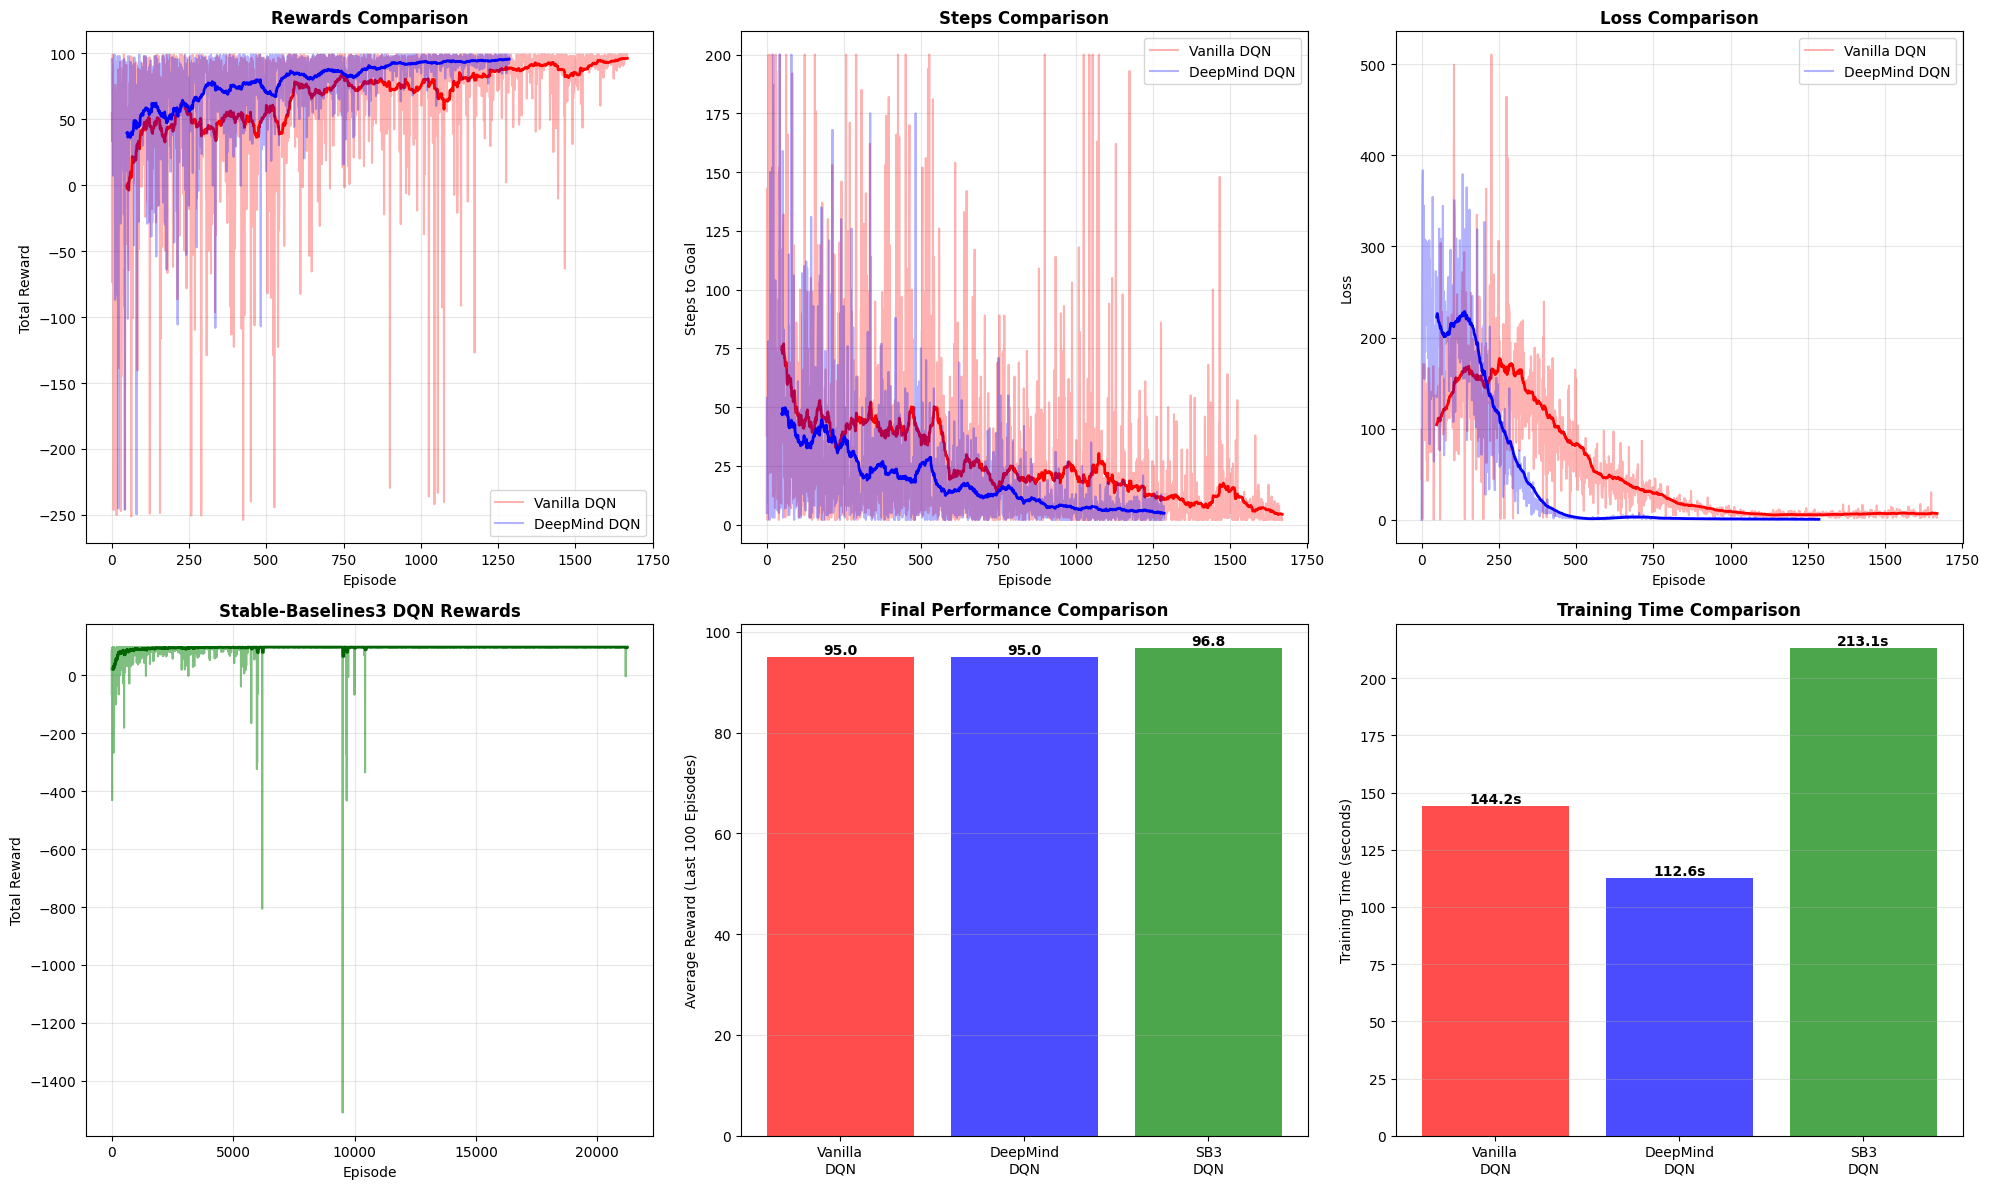


COMPARISON SUMMARY

Algorithm                 Avg Reward      Avg Steps       Time (s)       
----------------------------------------------------------------------
Vanilla DQN               95.03           5.39            144.20         
DeepMind DQN              95.00           5.32            112.60         
Stable-Baselines3 DQN     96.76           3.99            213.12         

Key Improvements in DeepMind DQN:
  1. Experience Replay Buffer - breaks correlation in sequential data
  2. Target Network - stabilizes learning by fixing targets
  3. Batch Updates - more stable gradient estimates
  4. Adam Optimizer - adaptive learning rates

Stable-Baselines3 Additional Features:
  - Optimized implementation with extensive testing
  - Learning rate scheduling
  - Gradient clipping
  - Polyak averaging for target updates
  - Better exploration strategies
  - Logging and monitoring tools


Generating detailed comparison visualizations...

DETAILED ALGORITHM COMPARISON

Training all alg

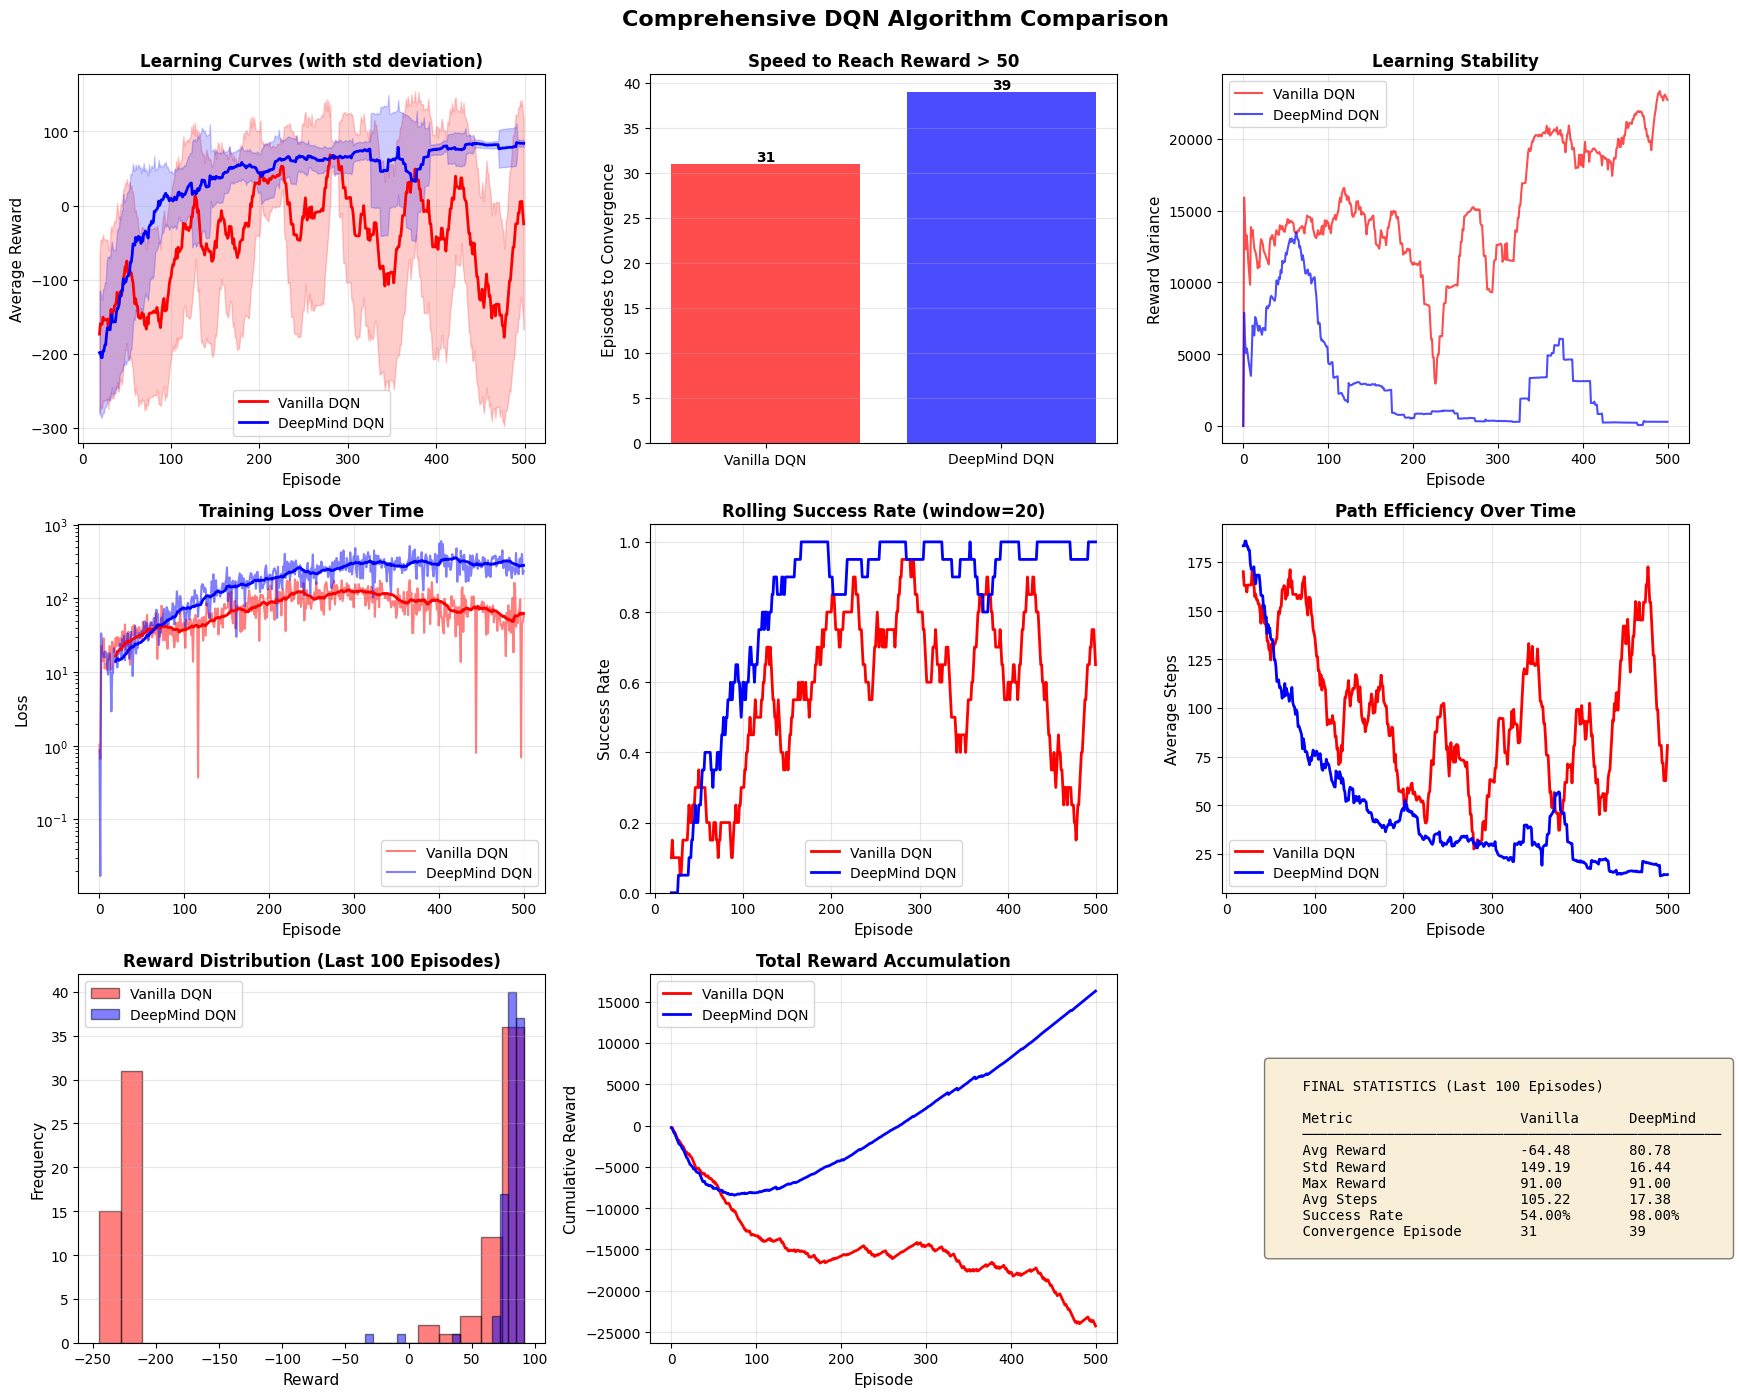


TESTING VANILLA_DQN
Target Goal: 2
Steps: 200, Total Reward: -227.31
Goal Reached: False
✓ Saved visualization as 'vanilla_dqn_test_path.png'


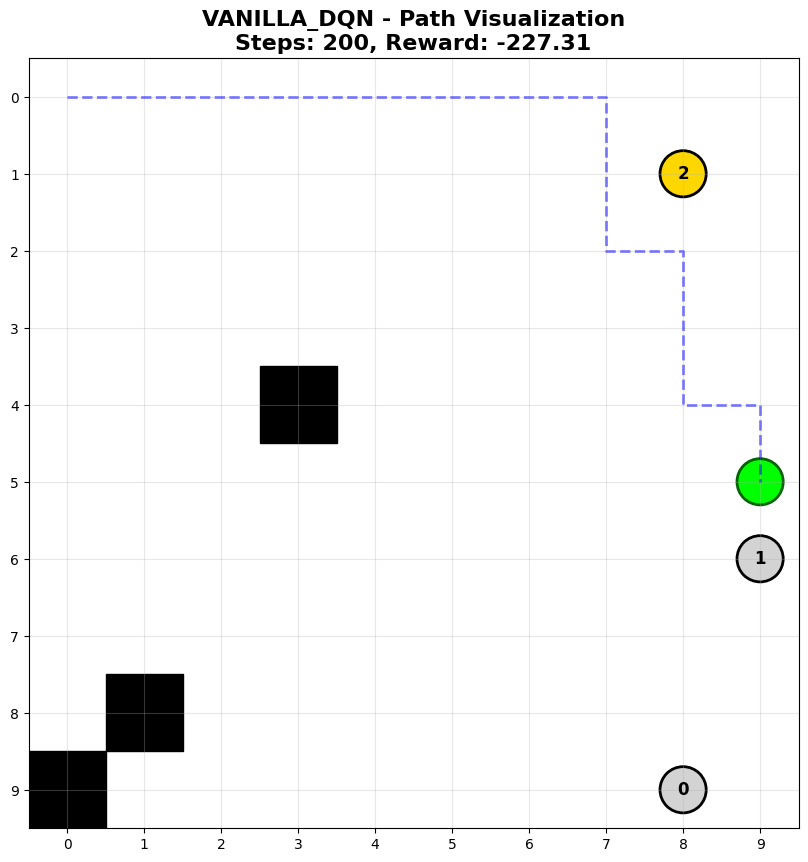


TESTING DEEPMIND_DQN
Target Goal: 1
Steps: 15, Total Reward: 83.08
Goal Reached: True
✓ Saved visualization as 'deepmind_dqn_test_path.png'


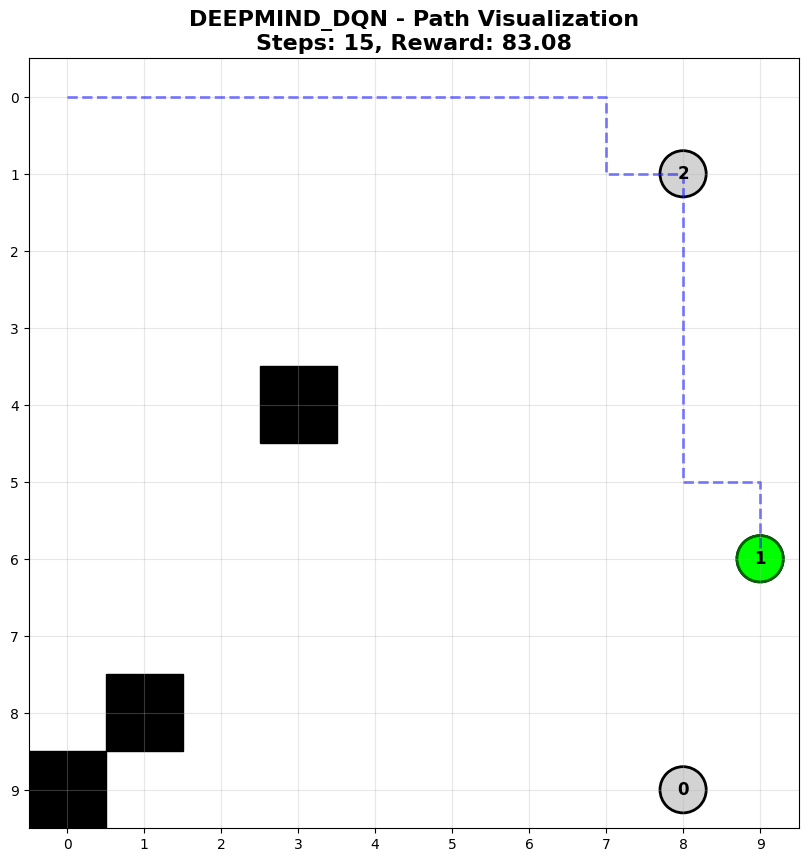

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from typing import Optional
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import time


class MultiGoalGridWorld(gym.Env):
    """Custom GridWorld Environment compatible with Gymnasium"""
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size: int = 10, target_goal: int = 0,
                 num_goals: int = 3, num_obstacles: int = 3):  # Reduced obstacles
        super().__init__()

        self.grid_size = grid_size
        self.num_goals = num_goals
        self.target_goal = target_goal
        self.num_obstacles = num_obstacles

        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.action_space = spaces.Discrete(4)

        # Observation: [agent_x, agent_y, goal_x, goal_y], normalized to [0, 1]
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(4,), dtype=np.float32
        )

        self.agent_pos = np.array([0, 0])
        self.goals = []
        self.obstacles = []
        self._generate_world()

    def _generate_world(self):
        self.goals = []
        self.obstacles = []

        available_positions = [
            (x, y) for x in range(self.grid_size)
            for y in range(self.grid_size)
            if (x, y) != tuple(self.agent_pos)
        ]

        total_needed = min(self.num_goals + self.num_obstacles, len(available_positions))
        selected_indices = np.random.choice(
            len(available_positions), size=total_needed, replace=False
        )

        for i in range(min(self.num_goals, total_needed)):
            idx = selected_indices[i]
            self.goals.append(np.array(available_positions[idx]))

        for i in range(self.num_goals, total_needed):
            idx = selected_indices[i]
            self.obstacles.append(np.array(available_positions[idx]))

    def _is_obstacle(self, pos: np.ndarray) -> bool:
        return any(np.array_equal(pos, obs) for obs in self.obstacles)

    def _get_obs(self):
        target_pos = self.goals[self.target_goal]
        # Normalize positions to [0, 1]
        normalized_state = np.concatenate([
            self.agent_pos / (self.grid_size - 1),
            target_pos / (self.grid_size - 1)
        ]).astype(np.float32)
        return normalized_state

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.agent_pos = np.array([0, 0])

        if self.target_goal >= len(self.goals):
            self.target_goal = 0

        return self._get_obs(), {}

    def step(self, action: int):
        direction_map = {
            0: np.array([-1, 0]),  # UP
            1: np.array([0, 1]),   # RIGHT
            2: np.array([1, 0]),   # DOWN
            3: np.array([0, -1])   # LEFT
        }

        new_pos = self.agent_pos + direction_map[action]
        new_pos = np.clip(new_pos, 0, self.grid_size - 1)

        if not self._is_obstacle(new_pos):
            self.agent_pos = new_pos

        target_pos = self.goals[self.target_goal]
        reached_goal = np.array_equal(self.agent_pos, target_pos)

        # Simplified reward shaping: Normalized distance penalty
        curr_distance = np.sum(np.abs(self.agent_pos - target_pos)) / (2 * (self.grid_size - 1))
        if reached_goal:
            reward = 100.0
            terminated = True
        else:
            reward = -1.0 - 0.5 * curr_distance  # Reduced penalty
            terminated = False

        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

    def render_grid(self, ax=None, agent_path=None, current_step=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        ax.clear()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.invert_yaxis()

        for obs in self.obstacles:
            rect = Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                           facecolor='black', edgecolor='black')
            ax.add_patch(rect)

        for idx, goal in enumerate(self.goals):
            color = 'gold' if idx == self.target_goal else 'lightgray'
            circle = Circle((goal[1], goal[0]), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(goal[1], goal[0], str(idx), ha='center', va='center',
                   fontsize=12, fontweight='bold')

        if agent_path and len(agent_path) > 1:
            # Convert normalized path back to grid coordinates
            path_array = np.array([p[:2] * (self.grid_size - 1) for p in agent_path])
            ax.plot(path_array[:, 1], path_array[:, 0], 'b--', alpha=0.5, linewidth=2)

        agent_circle = Circle((self.agent_pos[1], self.agent_pos[0]), 0.3,
                             color='lime', ec='darkgreen', linewidth=2)
        ax.add_patch(agent_circle)

        title = f'GridWorld - Target Goal: {self.target_goal}'
        if current_step is not None:
            title += f' | Step: {current_step}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        return ax


# ============================================================================
# VANILLA DQN (With Target Network and Replay Buffer)
# ============================================================================

class VanillaQNetwork(nn.Module):
    """Simplified Q-Network with two layers"""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 64):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return self.fc2(x)


class ReplayBuffer:
    """Experience Replay Buffer"""
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class VanillaDQNAgent:
    """Vanilla DQN with target network and replay buffer"""
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0001,
                 discount_factor: float = 0.99, epsilon: float = 1.0,
                 epsilon_min: float = 0.01, buffer_size: int = 10000, batch_size: int = 32):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.q_network = VanillaQNetwork(state_size, action_size)
        self.target_network = VanillaQNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update(self):
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self, episode: int, total_episodes: int):
        self.epsilon = max(self.epsilon_min, 1.0 - (episode / total_episodes) * (1.0 - self.epsilon_min))


# ============================================================================
# DEEPMIND DQN (Simplified, Without Double DQN)
# ============================================================================

class DeepMindQNetwork(nn.Module):
    """Simplified Q-Network with three layers"""
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 128):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DeepMindDQNAgent:
    """DQN with DeepMind improvements: Target Network, Replay Buffer"""
    def __init__(self, state_size: int, action_size: int, learning_rate: float = 0.0001,
                 discount_factor: float = 0.99, epsilon: float = 1.0,
                 epsilon_min: float = 0.01, buffer_size: int = 10000, batch_size: int = 32):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.q_network = DeepMindQNetwork(state_size, action_size)
        self.target_network = DeepMindQNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def get_action(self, state: np.ndarray) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def update(self):
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self, episode: int, total_episodes: int):
        self.epsilon = max(self.epsilon_min, 1.0 - (episode / total_episodes) * (1.0 - self.epsilon_min))


# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_vanilla_dqn(env, episodes=2000, early_stop_reward=95):
    """Train Improved Vanilla DQN"""
    agent = VanillaDQNAgent(
        state_size=4,
        action_size=env.action_space.n,
        learning_rate=0.0001,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=32
    )

    episode_rewards = []
    episode_steps = []
    episode_losses = []

    print("\n" + "="*70)
    print("TRAINING VANILLA DQN (With Target Network + Replay Buffer)")
    print("="*70)

    target_update_freq = 10
    for episode in range(episodes):
        env.target_goal = np.random.randint(0, env.num_goals)
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.update()

            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()

        agent.decay_epsilon(episode, episodes)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

        if episode >= 100 and np.mean(episode_rewards[-100:]) >= early_stop_reward:
            print(f"Early stopping at episode {episode + 1} with avg reward {np.mean(episode_rewards[-100:]):.2f}")
            break

    return agent, episode_rewards, episode_steps, episode_losses


def train_deepmind_dqn(env, episodes=2000, early_stop_reward=95):
    """Train Improved DeepMind DQN"""
    agent = DeepMindDQNAgent(
        state_size=4,
        action_size=env.action_space.n,
        learning_rate=0.0001,
        discount_factor=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        buffer_size=10000,
        batch_size=32
    )

    episode_rewards = []
    episode_steps = []
    episode_losses = []

    print("\n" + "="*70)
    print("TRAINING DEEPMIND DQN (With Target Network + Replay Buffer)")
    print("="*70)

    target_update_freq = 10
    for episode in range(episodes):
        env.target_goal = np.random.randint(0, env.num_goals)
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        episode_loss = 0
        loss_count = 0

        while not done and steps < 200:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.update()

            if loss is not None:
                episode_loss += loss
                loss_count += 1

            state = next_state
            total_reward += reward
            steps += 1

        if (episode + 1) % target_update_freq == 0:
            agent.update_target_network()

        agent.decay_epsilon(episode, episodes)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        episode_losses.append(episode_loss / max(loss_count, 1))

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_steps = np.mean(episode_steps[-100:])
            print(f"Episode {episode + 1}/{episodes} - "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Avg Steps: {avg_steps:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}")

        if episode >= 100 and np.mean(episode_rewards[-100:]) >= early_stop_reward:
            print(f"Early stopping at episode {episode + 1} with avg reward {np.mean(episode_rewards[-100:]):.2f}")
            break

    return agent, episode_rewards, episode_steps, episode_losses


class MetricsCallback(BaseCallback):
    """Callback to track training metrics for Stable-Baselines3"""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_steps = []
        self.current_episode_reward = 0
        self.current_episode_steps = 0

    def _on_step(self):
        self.current_episode_reward += self.locals['rewards'][0]
        self.current_episode_steps += 1

        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_steps.append(self.current_episode_steps)
            self.current_episode_reward = 0
            self.current_episode_steps = 0
        return True


def train_sb3_dqn(env, total_timesteps=100000):
    """Train using Stable-Baselines3 DQN"""
    print("\n" + "="*70)
    print("TRAINING STABLE-BASELINES3 DQN (Modern Implementation)")
    print("="*70)

    env = Monitor(env)
    callback = MetricsCallback()

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=0.0001,  # Match other agents
        buffer_size=10000,
        learning_starts=1000,
        batch_size=32,  # Match other agents
        gamma=0.99,
        train_freq=4,
        target_update_interval=1000,
        exploration_fraction=0.5,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.01,
        verbose=1
    )

    model.learn(total_timesteps=total_timesteps, callback=callback)

    return model, callback.episode_rewards, callback.episode_steps


# ============================================================================
# COMPARISON AND VISUALIZATION
# ============================================================================

def compare_algorithms():
    """Compare all three DQN implementations"""

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=5,
        target_goal=0,
        num_goals=3,
        num_obstacles=3  # Reduced obstacles
    )

    episodes = 2000

    # Train all three algorithms
    start_time = time.time()
    vanilla_agent, vanilla_rewards, vanilla_steps, vanilla_losses = train_vanilla_dqn(env, episodes)
    vanilla_time = time.time() - start_time

    start_time = time.time()
    deepmind_agent, deepmind_rewards, deepmind_steps, deepmind_losses = train_deepmind_dqn(env, episodes)
    deepmind_time = time.time() - start_time

    start_time = time.time()
    sb3_model, sb3_rewards, sb3_steps = train_sb3_dqn(env, total_timesteps=episodes * 50)
    sb3_time = time.time() - start_time

    # Create comprehensive comparison plots
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Rewards Comparison
    ax1 = plt.subplot(2, 3, 1)
    window = 50
    ax1.plot(vanilla_rewards, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_rewards) >= window:
        moving_avg = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(vanilla_rewards)), moving_avg, color='red', linewidth=2)

    ax1.plot(deepmind_rewards, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_rewards) >= window:
        moving_avg = np.convolve(deepmind_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(deepmind_rewards)), moving_avg, color='blue', linewidth=2)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Rewards Comparison', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Steps Comparison
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(vanilla_steps, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_steps) >= window:
        moving_avg = np.convolve(vanilla_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(vanilla_steps)), moving_avg, color='red', linewidth=2)

    ax2.plot(deepmind_steps, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_steps) >= window:
        moving_avg = np.convolve(deepmind_steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(deepmind_steps)), moving_avg, color='blue', linewidth=2)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps to Goal')
    ax2.set_title('Steps Comparison', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Loss Comparison
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(vanilla_losses, alpha=0.3, color='red', label='Vanilla DQN')
    if len(vanilla_losses) >= window:
        moving_avg = np.convolve(vanilla_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(vanilla_losses)), moving_avg, color='red', linewidth=2)

    ax3.plot(deepmind_losses, alpha=0.3, color='blue', label='DeepMind DQN')
    if len(deepmind_losses) >= window:
        moving_avg = np.convolve(deepmind_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(deepmind_losses)), moving_avg, color='blue', linewidth=2)

    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss Comparison', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: SB3 Rewards
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(sb3_rewards, alpha=0.5, color='green')
    if len(sb3_rewards) >= window:
        moving_avg = np.convolve(sb3_rewards, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(sb3_rewards)), moving_avg, color='darkgreen', linewidth=2)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Total Reward')
    ax4.set_title('Stable-Baselines3 DQN Rewards', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Performance Summary
    ax5 = plt.subplot(2, 3, 5)
    final_rewards = [
        np.mean(vanilla_rewards[-100:]),
        np.mean(deepmind_rewards[-100:]),
        np.mean(sb3_rewards[-100:]) if len(sb3_rewards) >= 100 else np.mean(sb3_rewards)
    ]
    algorithms = ['Vanilla\nDQN', 'DeepMind\nDQN', 'SB3\nDQN']
    colors = ['red', 'blue', 'green']
    bars = ax5.bar(algorithms, final_rewards, color=colors, alpha=0.7)
    ax5.set_ylabel('Average Reward (Last 100 Episodes)')
    ax5.set_title('Final Performance Comparison', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')

    for bar, reward in zip(bars, final_rewards):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{reward:.1f}', ha='center', va='bottom', fontweight='bold')

    # Plot 6: Training Time Comparison
    ax6 = plt.subplot(2, 3, 6)
    times = [vanilla_time, deepmind_time, sb3_time]
    bars = ax6.bar(algorithms, times, color=colors, alpha=0.7)
    ax6.set_ylabel('Training Time (seconds)')
    ax6.set_title('Training Time Comparison', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    for bar, t in zip(bars, times):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('dqn_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Comparison plot saved as 'dqn_comparison.png'")
    plt.show()

    # Print summary
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    print(f"\n{'Algorithm':<25} {'Avg Reward':<15} {'Avg Steps':<15} {'Time (s)':<15}")
    print("-" * 70)
    print(f"{'Vanilla DQN':<25} {np.mean(vanilla_rewards[-100:]):<15.2f} {np.mean(vanilla_steps[-100:]):<15.2f} {vanilla_time:<15.2f}")
    print(f"{'DeepMind DQN':<25} {np.mean(deepmind_rewards[-100:]):<15.2f} {np.mean(deepmind_steps[-100:]):<15.2f} {deepmind_time:<15.2f}")
    print(f"{'Stable-Baselines3 DQN':<25} {np.mean(sb3_rewards[-100:]) if len(sb3_rewards) >= 100 else np.mean(sb3_rewards):<15.2f} {np.mean(sb3_steps[-100:]) if len(sb3_steps) >= 100 else np.mean(sb3_steps):<15.2f} {sb3_time:<15.2f}")
    print("="*70)

    print("\nKey Improvements in DeepMind DQN:")
    print("  1. Experience Replay Buffer - breaks correlation in sequential data")
    print("  2. Target Network - stabilizes learning by fixing targets")
    print("  3. Batch Updates - more stable gradient estimates")
    print("  4. Adam Optimizer - adaptive learning rates")

    print("\nStable-Baselines3 Additional Features:")
    print("  - Optimized implementation with extensive testing")
    print("  - Learning rate scheduling")
    print("  - Gradient clipping")
    print("  - Polyak averaging for target updates")
    print("  - Better exploration strategies")
    print("  - Logging and monitoring tools")

    return vanilla_agent, deepmind_agent, sb3_model


def test_agent(agent, env, agent_type="agent"):
    """Test a trained agent and visualize its performance"""
    print(f"\n{'='*70}")
    print(f"TESTING {agent_type.upper()}")
    print(f"{'='*70}")

    env.target_goal = np.random.randint(0, env.num_goals)
    print(f"Target Goal: {env.target_goal}")

    state, _ = env.reset()
    done = False
    steps = 0
    total_reward = 0
    agent_path = [state.copy()]

    while not done and steps < 200:
        if agent_type == "sb3":
            action, _ = agent.predict(state, deterministic=True)
        elif hasattr(agent, 'get_action'):
            old_epsilon = agent.epsilon
            agent.epsilon = 0  # Greedy policy
            action = agent.get_action(state)
            agent.epsilon = old_epsilon
        else:
            action = agent.get_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent_path.append(next_state.copy())
        state = next_state
        total_reward += reward
        steps += 1

    print(f"Steps: {steps}, Total Reward: {total_reward:.2f}")
    print(f"Goal Reached: {done}")

    # Visualize the path
    fig, ax = plt.subplots(figsize=(10, 10))
    env.render_grid(ax, agent_path=agent_path, current_step=steps)
    plt.title(f'{agent_type.upper()} - Path Visualization\nSteps: {steps}, Reward: {total_reward:.2f}',
              fontsize=16, fontweight='bold')
    filename = f'{agent_type}_test_path.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Saved visualization as '{filename}'")
    plt.show()

    return steps, total_reward


def detailed_comparison_visualization():
    """Create detailed visualizations showing the differences between algorithms"""

    print("\n" + "="*70)
    print("DETAILED ALGORITHM COMPARISON")
    print("="*70)

    # Create environment
    env = MultiGoalGridWorld(
        grid_size=10,
        target_goal=0,
        num_goals=3,
        num_obstacles=3
    )

    # Train with fewer episodes for quick comparison
    episodes = 500

    print("\nTraining all algorithms...")
    vanilla_agent, vanilla_rewards, vanilla_steps, vanilla_losses = train_vanilla_dqn(env, episodes)
    deepmind_agent, deepmind_rewards, deepmind_steps, deepmind_losses = train_deepmind_dqn(env, episodes)

    # Create detailed comparison figure
    fig = plt.figure(figsize=(18, 14))

    # 1. Learning Curves with Statistical Bands
    ax1 = plt.subplot(3, 3, 1)
    window = 20

    # Vanilla DQN
    vanilla_mean = np.convolve(vanilla_rewards, np.ones(window)/window, mode='valid')
    vanilla_std = np.array([np.std(vanilla_rewards[max(0,i-window):i+1])
                            for i in range(window-1, len(vanilla_rewards))])
    x_vanilla = range(window-1, len(vanilla_rewards))
    ax1.plot(x_vanilla, vanilla_mean, 'r-', linewidth=2, label='Vanilla DQN')
    ax1.fill_between(x_vanilla, vanilla_mean - vanilla_std, vanilla_mean + vanilla_std,
                     color='red', alpha=0.2)

    # DeepMind DQN
    deepmind_mean = np.convolve(deepmind_rewards, np.ones(window)/window, mode='valid')
    deepmind_std = np.array([np.std(deepmind_rewards[max(0,i-window):i+1])
                             for i in range(window-1, len(deepmind_rewards))])
    x_deepmind = range(window-1, len(deepmind_rewards))
    ax1.plot(x_deepmind, deepmind_mean, 'b-', linewidth=2, label='DeepMind DQN')
    ax1.fill_between(x_deepmind, deepmind_mean - deepmind_std, deepmind_mean + deepmind_std,
                     color='blue', alpha=0.2)

    ax1.set_xlabel('Episode', fontsize=11)
    ax1.set_ylabel('Average Reward', fontsize=11)
    ax1.set_title('Learning Curves (with std deviation)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Convergence Speed
    ax2 = plt.subplot(3, 3, 2)
    target_reward = 50
    vanilla_convergence = next((i for i, r in enumerate(vanilla_rewards) if r > target_reward), episodes)
    deepmind_convergence = next((i for i, r in enumerate(deepmind_rewards) if r > target_reward), episodes)

    bars = ax2.bar(['Vanilla DQN', 'DeepMind DQN'],
                   [vanilla_convergence, deepmind_convergence],
                   color=['red', 'blue'], alpha=0.7)
    ax2.set_ylabel('Episodes to Convergence', fontsize=11)
    ax2.set_title(f'Speed to Reach Reward > {target_reward}', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # 3. Stability Analysis (Variance over time)
    ax3 = plt.subplot(3, 3, 3)
    window_size = 50
    vanilla_variance = [np.var(vanilla_rewards[max(0,i-window_size):i+1])
                       for i in range(len(vanilla_rewards))]
    deepmind_variance = [np.var(deepmind_rewards[max(0,i-window_size):i+1])
                        for i in range(len(deepmind_rewards))]

    ax3.plot(vanilla_variance, 'r-', alpha=0.7, label='Vanilla DQN')
    ax3.plot(deepmind_variance, 'b-', alpha=0.7, label='DeepMind DQN')
    ax3.set_xlabel('Episode', fontsize=11)
    ax3.set_ylabel('Reward Variance', fontsize=11)
    ax3.set_title('Learning Stability', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Loss Progression
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(vanilla_losses, 'r-', alpha=0.5, label='Vanilla DQN')
    ax4.plot(deepmind_losses, 'b-', alpha=0.5, label='DeepMind DQN')

    if len(vanilla_losses) >= window:
        vanilla_loss_smooth = np.convolve(vanilla_losses, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(vanilla_losses)), vanilla_loss_smooth, 'r-', linewidth=2)
    if len(deepmind_losses) >= window:
        deepmind_loss_smooth = np.convolve(deepmind_losses, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(deepmind_losses)), deepmind_loss_smooth, 'b-', linewidth=2)

    ax4.set_xlabel('Episode', fontsize=11)
    ax4.set_ylabel('Loss', fontsize=11)
    ax4.set_title('Training Loss Over Time', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # 5. Success Rate
    ax5 = plt.subplot(3, 3, 5)
    vanilla_success = [1 if r > 0 else 0 for r in vanilla_rewards]
    deepmind_success = [1 if r > 0 else 0 for r in deepmind_rewards]

    vanilla_success_rate = np.convolve(vanilla_success, np.ones(window)/window, mode='valid')
    deepmind_success_rate = np.convolve(deepmind_success, np.ones(window)/window, mode='valid')

    ax5.plot(range(window-1, len(vanilla_rewards)), vanilla_success_rate, 'r-', linewidth=2, label='Vanilla DQN')
    ax5.plot(range(window-1, len(deepmind_rewards)), deepmind_success_rate, 'b-', linewidth=2, label='DeepMind DQN')
    ax5.set_xlabel('Episode', fontsize=11)
    ax5.set_ylabel('Success Rate', fontsize=11)
    ax5.set_title(f'Rolling Success Rate (window={window})', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim([0, 1.05])

    # 6. Steps Efficiency
    ax6 = plt.subplot(3, 3, 6)
    vanilla_steps_smooth = np.convolve(vanilla_steps, np.ones(window)/window, mode='valid')
    deepmind_steps_smooth = np.convolve(deepmind_steps, np.ones(window)/window, mode='valid')

    ax6.plot(range(window-1, len(vanilla_steps)), vanilla_steps_smooth, 'r-', linewidth=2, label='Vanilla DQN')
    ax6.plot(range(window-1, len(deepmind_steps)), deepmind_steps_smooth, 'b-', linewidth=2, label='DeepMind DQN')
    ax6.set_xlabel('Episode', fontsize=11)
    ax6.set_ylabel('Average Steps', fontsize=11)
    ax6.set_title('Path Efficiency Over Time', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. Performance Distribution
    ax7 = plt.subplot(3, 3, 7)
    last_100_vanilla = vanilla_rewards[-100:]
    last_100_deepmind = deepmind_rewards[-100:]

    ax7.hist(last_100_vanilla, bins=20, alpha=0.5, color='red', label='Vanilla DQN', edgecolor='black')
    ax7.hist(last_100_deepmind, bins=20, alpha=0.5, color='blue', label='DeepMind DQN', edgecolor='black')
    ax7.set_xlabel('Reward', fontsize=11)
    ax7.set_ylabel('Frequency', fontsize=11)
    ax7.set_title('Reward Distribution (Last 100 Episodes)', fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3, axis='y')

    # 8. Cumulative Reward
    ax8 = plt.subplot(3, 3, 8)
    vanilla_cumulative = np.cumsum(vanilla_rewards)
    deepmind_cumulative = np.cumsum(deepmind_rewards)

    ax8.plot(vanilla_cumulative, 'r-', linewidth=2, label='Vanilla DQN')
    ax8.plot(deepmind_cumulative, 'b-', linewidth=2, label='DeepMind DQN')
    ax8.set_xlabel('Episode', fontsize=11)
    ax8.set_ylabel('Cumulative Reward', fontsize=11)
    ax8.set_title('Total Reward Accumulation', fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # 9. Final Statistics Table
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    stats_text = f"""
    FINAL STATISTICS (Last 100 Episodes)

    {'Metric':<25} {'Vanilla':<12} {'DeepMind':<12}
    {'─'*50}
    {'Avg Reward':<25} {np.mean(last_100_vanilla):<12.2f} {np.mean(last_100_deepmind):<12.2f}
    {'Std Reward':<25} {np.std(last_100_vanilla):<12.2f} {np.std(last_100_deepmind):<12.2f}
    {'Max Reward':<25} {np.max(last_100_vanilla):<12.2f} {np.max(last_100_deepmind):<12.2f}
    {'Avg Steps':<25} {np.mean(vanilla_steps[-100:]):<12.2f} {np.mean(deepmind_steps[-100:]):<12.2f}
    {'Success Rate':<25} {np.mean([1 if r>0 else 0 for r in last_100_vanilla]):<12.2%} {np.mean([1 if r>0 else 0 for r in last_100_deepmind]):<12.2%}
    {'Convergence Episode':<25} {vanilla_convergence:<12d} {deepmind_convergence:<12d}
    """

    ax9.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10,
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.suptitle('Comprehensive DQN Algorithm Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('detailed_dqn_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Detailed comparison saved as 'detailed_dqn_comparison.png'")
    plt.show()

    # Test both agents
    test_agent(vanilla_agent, env, "vanilla_dqn")
    test_agent(deepmind_agent, env, "deepmind_dqn")

    return vanilla_agent, deepmind_agent


if __name__ == "__main__":
    # Run full comparison
    vanilla_agent, deepmind_agent, sb3_model = compare_algorithms()

    # Run detailed visualization
    print("\n\nGenerating detailed comparison visualizations...")
    detailed_comparison_visualization()